In [ ]:
!pip install nsepy

  Preparing metadata (setup.py) ... done
  Created wheel for nsepy: filename=nsepy-0.8-py3-none-any.whl size=36057 sha256=82de8335f5d1c3506d37b6889412637644a26629c16bc3dde0bd00fb84fed8c2
  Stored in directory: /root/.cache/pip/wheels/ba/d6/a0/a2c830ea2a083f15d9790732c1908625dd6314a02f09a92130
Successfully built nsepy


In [ ]:
import yfinance as yf
import pandas as pd
from nsepy import get_history
from datetime import date, timedelta

# 1. India VIX
india_vix = get_history(symbol="INDIAVIX", start=date(2020,1,1),
                        end=date(2024,1,1), index=True)

# 2. NIFTY for returns and realized vol
nifty = get_history(symbol="NIFTY 50", start=date(2020,1,1),
                    end=date(2024,1,1), index=True)
nifty['returns'] = nifty['Close'].pct_change()
nifty['realized_vol_30d'] = nifty['returns'].rolling(30).std() * np.sqrt(252)

# 3. USD/INR
usdinr = yf.download('USDINR=X', start='2020-01-01', end='2024-01-01')

# 4. Crude Oil
crude = yf.download('BZ=F', start='2020-01-01', end='2024-01-01')

# 5. S&P 500 VIX
sp_vix = yf.download('^VIX', start='2020-01-01', end='2024-01-01')

# Merge all on date
conditioning_data = pd.concat([
    india_vix[['Close']].rename(columns={'Close': 'india_vix'}),
    nifty[['realized_vol_30d', 'returns']],
    usdinr[['Close']].rename(columns={'Close': 'usdinr'}),
    crude[['Close']].rename(columns={'Close': 'crude'}),
    sp_vix[['Close']].rename(columns={'Close': 'sp_vix'})
], axis=1)

Exception in thread Thread-9 (get_history):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py", line 464, in _make_request
Exception in thread Thread-11 (get_history):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py", line 464, in _make_request
Exception in thread Thread-17 (get_history):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py", line 464, in _make_request
    self._validate_conn(conn)
  File "/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py", line 1093, in _validate_conn
    self._validate_conn(conn)
  File "/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py", line 1093, in _validate_conn
    self._validate_conn(conn)
  File "/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py", line 1093, in _validate_conn
    conn.connect()
  File "/usr/local/lib/pytho

AttributeError: 'ThreadReturns' object has no attribute 'result'

In [ ]:
"""
Collect Conditioning Variables for CVAE
Frequency: Daily (aligned with calibration dates)
"""

import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import pickle
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("COLLECTING CONDITIONING VARIABLES FOR CVAE")
print("=" * 80)

# ============================================================================
# 1. Load Calibration Dates
# ============================================================================

print("\n1. Loading calibration dates...")
with open('NIFTY_heston_single_params.pickle', 'rb') as f:
    calib_data = pickle.load(f)

dates = calib_data['dates']
print(f"    Found {len(dates)} calibration dates")
print(f"    Date range: {dates[0]} to {dates[-1]}")

# Convert to datetime
dates_dt = pd.to_datetime(dates)
start_date = dates_dt.min() - timedelta(days=60)  # Extra for rolling calculations
end_date = dates_dt.max()

print(f"    Fetching data from {start_date.date()} to {end_date.date()}")

# ============================================================================
# 2. Collect Market Data
# ============================================================================

print("\n2. Collecting market data...")

# NIFTY 50 (for returns and realized vol)
print("   - NIFTY 50...")
try:
    nifty = yf.download('^NSEI', start=start_date, end=end_date, progress=False)
    nifty['returns'] = nifty['Close'].pct_change()
    nifty['returns_5d'] = nifty['Close'].pct_change(5)
    nifty['returns_20d'] = nifty['Close'].pct_change(20)
    nifty['realized_vol_30d'] = nifty['returns'].rolling(30).std() * np.sqrt(252)
    print(f"      NIFTY: {len(nifty)} days")
except Exception as e:
    print(f"      NIFTY failed: {e}")
    nifty = pd.DataFrame()

# India VIX (try multiple methods)
print("   - India VIX...")
try:
    # Method 1: Try yfinance
    india_vix = yf.download('^INDIAVIX', start=start_date, end=end_date, progress=False)
    if len(india_vix) == 0:
        raise Exception("No data from yfinance")
    print(f"      India VIX: {len(india_vix)} days")
except:
    try:
        # Method 2: Try NSEpy
        from nsepy import get_history
        india_vix = get_history(symbol="INDIAVIX",
                               start=start_date.date(),
                               end=end_date.date(),
                               index=True)
        india_vix = india_vix[['Close']]
        print(f"      India VIX (NSEpy): {len(india_vix)} days")
    except Exception as e:
        print(f"      India VIX not available: {e}")
        print(f"     → Will use NIFTY realized vol as proxy")
        india_vix = pd.DataFrame()

# USD/INR
print("   - USD/INR...")
try:
    usdinr = yf.download('USDINR=X', start=start_date, end=end_date, progress=False)
    print(f"      USD/INR: {len(usdinr)} days")
except Exception as e:
    print(f"      USD/INR failed: {e}")
    usdinr = pd.DataFrame()

# Crude Oil (Brent)
print("   - Crude Oil (Brent)...")
try:
    crude = yf.download('BZ=F', start=start_date, end=end_date, progress=False)
    print(f"      Crude Oil: {len(crude)} days")
except Exception as e:
    print(f"      Crude Oil failed: {e}")
    crude = pd.DataFrame()

# S&P 500 VIX
print("   - S&P 500 VIX...")
try:
    sp_vix = yf.download('^VIX', start=start_date, end=end_date, progress=False)
    print(f"      S&P VIX: {len(sp_vix)} days")
except Exception as e:
    print(f"      S&P VIX failed: {e}")
    sp_vix = pd.DataFrame()

# US 10Y Treasury Yield
print("   - US 10Y Yield...")
try:
    us10y = yf.download('^TNX', start=start_date, end=end_date, progress=False)
    print(f"      US 10Y: {len(us10y)} days")
except Exception as e:
    print(f"      US 10Y failed: {e}")
    us10y = pd.DataFrame()

# ============================================================================
# 3. Create Conditioning Variables DataFrame
# ============================================================================

print("\n3. Creating conditioning variables dataframe...")

conditioning_vars = pd.DataFrame(index=dates_dt)

# Add NIFTY-based variables
if not nifty.empty:
    conditioning_vars['nifty_return_1d'] = nifty['returns'].reindex(dates_dt)
    conditioning_vars['nifty_return_5d'] = nifty['returns_5d'].reindex(dates_dt)
    conditioning_vars['nifty_return_20d'] = nifty['returns_20d'].reindex(dates_dt)
    conditioning_vars['nifty_realized_vol_30d'] = nifty['realized_vol_30d'].reindex(dates_dt)

# Add India VIX
if not india_vix.empty:
    conditioning_vars['india_vix'] = india_vix['Close'].reindex(dates_dt)
else:
    # Use realized vol as proxy if VIX not available
    if not nifty.empty:
        conditioning_vars['india_vix'] = conditioning_vars['nifty_realized_vol_30d']
        print("    Using NIFTY realized vol as India VIX proxy")

# Add USD/INR
if not usdinr.empty:
    conditioning_vars['usdinr'] = usdinr['Close'].reindex(dates_dt)

# Add Crude Oil
if not crude.empty:
    conditioning_vars['crude_oil'] = crude['Close'].reindex(dates_dt)

# Add S&P VIX
if not sp_vix.empty:
    conditioning_vars['sp_vix'] = sp_vix['Close'].reindex(dates_dt)

# Add US 10Y Yield
if not us10y.empty:
    conditioning_vars['us_10y_yield'] = us10y['Close'].reindex(dates_dt)

# ============================================================================
# 4. Add Calendar/Event Variables
# ============================================================================

print("\n4. Adding calendar/event variables...")

# Day of week (0=Monday, 4=Friday)
conditioning_vars['day_of_week'] = conditioning_vars.index.dayofweek

# Month (1-12)
conditioning_vars['month'] = conditioning_vars.index.month

# Quarter end proximity (days to quarter end)
def days_to_quarter_end(date):
    quarter_ends = pd.date_range(start=date.year, periods=4, freq='Q')
    future_ends = quarter_ends[quarter_ends >= date]
    if len(future_ends) > 0:
        return (future_ends[0] - date).days
    else:
        next_year_end = pd.Timestamp(f"{date.year+1}-03-31")
        return (next_year_end - date).days

conditioning_vars['days_to_quarter_end'] = conditioning_vars.index.map(days_to_quarter_end)

# Earnings season flag (Jan-Feb, Apr-May, Jul-Aug, Oct-Nov)
conditioning_vars['earnings_season'] = conditioning_vars['month'].isin([1, 2, 4, 5, 7, 8, 10, 11]).astype(int)

# RBI Meeting proximity (approximate - every 2 months)
# Typical months: Feb, Apr, Jun, Aug, Oct, Dec
rbi_months = [2, 4, 6, 8, 10, 12]
def days_to_rbi_meeting(date):
    # Find next RBI month
    current_month = date.month
    next_rbi_months = [m for m in rbi_months if m >= current_month]
    if next_rbi_months:
        next_month = next_rbi_months[0]
        next_meeting = pd.Timestamp(f"{date.year}-{next_month:02d}-08")  # Assume 8th of month
    else:
        next_meeting = pd.Timestamp(f"{date.year+1}-02-08")

    if next_meeting >= date:
        return (next_meeting - date).days
    else:
        return 0

conditioning_vars['days_to_rbi_meeting'] = conditioning_vars.index.map(days_to_rbi_meeting)

print(f"    Added {len(conditioning_vars.columns)} variables")

# ============================================================================
# 5. Handle Missing Values
# ============================================================================

print("\n5. Handling missing values...")

# Forward fill for macro variables (they don't change daily)
macro_vars = ['usdinr', 'crude_oil', 'us_10y_yield']
for var in macro_vars:
    if var in conditioning_vars.columns:
        conditioning_vars[var] = conditioning_vars[var].fillna(method='ffill')

# For other variables, forward fill then backward fill
conditioning_vars = conditioning_vars.fillna(method='ffill').fillna(method='bfill')

# Report missing values
missing_counts = conditioning_vars.isnull().sum()
if missing_counts.sum() > 0:
    print("    Remaining missing values:")
    for col, count in missing_counts[missing_counts > 0].items():
        print(f"     - {col}: {count} missing")
else:
    print("    No missing values")

# ============================================================================
# 6. Normalize Variables
# ============================================================================

print("\n6. Normalizing variables...")

# Save normalization stats
norm_stats = pd.DataFrame({
    'mean': conditioning_vars.mean(),
    'std': conditioning_vars.std()
})

# Z-score normalization
conditioning_vars_normalized = (conditioning_vars - norm_stats['mean']) / norm_stats['std']

print(f"    Normalized {len(conditioning_vars.columns)} variables")

# ============================================================================
# 7. Save Results
# ============================================================================

print("\n7. Saving results...")

# Save raw conditioning variables
conditioning_vars.to_pickle('conditioning_variables_raw.pickle')
print("    Saved: conditioning_variables_raw.pickle")

# Save normalized conditioning variables
conditioning_vars_normalized.to_pickle('conditioning_variables_normalized.pickle')
print("    Saved: conditioning_variables_normalized.pickle")

# Save normalization stats
norm_stats.to_pickle('conditioning_normalization_stats.pickle')
print("    Saved: conditioning_normalization_stats.pickle")

# Save as CSV for inspection
conditioning_vars.to_csv('conditioning_variables_raw.csv')
conditioning_vars_normalized.to_csv('conditioning_variables_normalized.csv')
print("    Saved CSV files for inspection")

# ============================================================================
# 8. Summary Statistics
# ============================================================================

print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)

print(f"\nTotal dates: {len(conditioning_vars)}")
print(f"Total variables: {len(conditioning_vars.columns)}")
print(f"\nVariables collected:")
for i, col in enumerate(conditioning_vars.columns, 1):
    print(f"  {i:2d}. {col}")

print(f"\nDate range: {conditioning_vars.index.min().date()} to {conditioning_vars.index.max().date()}")

print("\nRaw variable statistics:")
print(conditioning_vars.describe())

print("\n" + "=" * 80)
print(" CONDITIONING VARIABLES COLLECTION COMPLETE!")
print("=" * 80)
print("\nNext steps:")
print("1. Review conditioning_variables_raw.csv")
print("2. Use conditioning_variables_normalized.pickle for CVAE training")
print("3. Align with calibrated Heston parameters by date")
print("=" * 80)


COLLECTING CONDITIONING VARIABLES FOR CVAE

1. Loading calibration dates...
    Found 500 calibration dates
    Date range: 2016-02-09 to 2025-06-27
    Fetching data from 2015-12-11 to 2025-06-27

2. Collecting market data...
   - NIFTY 50...
      NIFTY: 2350 days
   - India VIX...
      India VIX: 2338 days
   - USD/INR...
      USD/INR: 2484 days
   - Crude Oil (Brent)...
      Crude Oil: 2398 days
   - S&P 500 VIX...
      S&P VIX: 2398 days
   - US 10Y Yield...
      US 10Y: 2397 days

3. Creating conditioning variables dataframe...

4. Adding calendar/event variables...
    Added 14 variables

5. Handling missing values...
    No missing values

6. Normalizing variables...
    Normalized 14 variables

7. Saving results...
    Saved: conditioning_variables_raw.pickle
    Saved: conditioning_variables_normalized.pickle
    Saved: conditioning_normalization_stats.pickle
    Saved CSV files for inspection

SUMMARY

Total dates: 500
Total variables: 14

Variables collected:
   1. nif

In [ ]:
import pandas as pd

# Load the raw conditioning variables
conditioning_vars_raw = pd.read_pickle('conditioning_variables_normalized.pickle')

# Display basic information
print("--- Head of the DataFrame ---")
display(conditioning_vars_raw.head())

print("\n--- DataFrame Info ---")
display(conditioning_vars_raw.info())

print("\n--- Descriptive Statistics ---")
display(conditioning_vars_raw.describe())

--- Head of the DataFrame ---


,nifty_return_1d,nifty_return_5d,nifty_return_20d,nifty_realized_vol_30d,india_vix,usdinr,crude_oil,sp_vix,us_10y_yield,day_of_week,month,days_to_quarter_end,earnings_season,days_to_rbi_meeting
2016-02-09,-0.994001,-0.949685,-0.849145,0.074866,0.581351,-2.296732,-2.590604,0.764989,-1.155302,-0.714265,-1.200778,1.252957,0.669609,-0.973833
2016-07-20,0.411427,0.200688,0.779518,-0.458480,-0.362785,-2.470880,-1.723915,-1.400560,-1.277106,0.010142,0.195475,-0.233372,0.669609,0.556338
2017-08-10,-0.720833,-0.872055,-0.260655,-0.820201,-0.723004,-3.135113,-1.480624,-0.774501,-0.760460,0.734548,0.474726,-0.426044,0.669609,-0.973833
2017-08-14,0.771575,-1.169386,-0.367393,-0.757283,-0.627604,-3.096419,-1.540804,-1.318454,-0.754737,-1.438671,0.474726,-0.462744,0.669609,-0.973833
2017-09-14,0.099229,0.648788,0.295179,-0.607666,-1.106251,-3.089594,-1.297000,-1.595563,-0.772722,0.734548,0.753977,-0.747165,-1.490421,0.959014



--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2016-02-09 to 2025-06-27
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   nifty_return_1d         500 non-null    float64
 1   nifty_return_5d         500 non-null    float64
 2   nifty_return_20d        500 non-null    float64
 3   nifty_realized_vol_30d  500 non-null    float64
 4   india_vix               500 non-null    float64
 5   usdinr                  500 non-null    float64
 6   crude_oil               500 non-null    float64
 7   sp_vix                  500 non-null    float64
 8   us_10y_yield            500 non-null    float64
 9   day_of_week             500 non-null    float64
 10  month                   500 non-null    float64
 11  days_to_quarter_end     500 non-null    float64
 12  earnings_season         500 non-null    float64
 13  days_to_rbi_meeting     500 non-null    float64
dtyp

None


--- Descriptive Statistics ---


,nifty_return_1d,nifty_return_5d,nifty_return_20d,nifty_realized_vol_30d,india_vix,usdinr,crude_oil,sp_vix,us_10y_yield,day_of_week,month,days_to_quarter_end,earnings_season,days_to_rbi_meeting
count,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02
mean,-7.105427e-18,2.842171e-17,-2.842171e-17,2.273737e-16,2.842171e-16,4.547474e-16,2.486900e-16,-1.421085e-16,1.136868e-16,1.687539e-17,6.394885e-17,1.847411e-16,1.776357e-16,-1.820766e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-5.035330e+00,-2.974006e+00,-4.744627e+00,-1.023035e+00,-1.301986e+00,-3.135113e+00,-2.751082e+00,-1.728985e+00,-2.147721e+00,-1.438671e+00,-1.480029e+00,-1.738051e+00,-1.490421e+00,-9.738325e-01
25%,-4.357986e-01,-6.223016e-01,-6.819783e-01,-5.337498e-01,-6.313045e-01,-8.263193e-01,-4.416266e-01,-8.305827e-01,-9.390787e-01,-7.142649e-01,-9.215272e-01,-8.939625e-01,-1.490421e+00,-9.738325e-01
50%,-2.882960e-03,4.356099e-02,-5.702035e-02,-2.497452e-01,-2.336653e-01,3.919044e-01,1.820720e-02,-1.411110e-01,3.018540e-01,1.014169e-02,-8.377520e-02,1.336228e-01,6.696094e-01,-3.295503e-01
75%,4.887545e-01,6.220961e-01,6.573859e-01,1.993212e-01,3.691670e-01,7.546515e-01,5.369346e-01,6.993771e-01,8.973871e-01,7.345483e-01,8.237895e-01,8.974306e-01,6.696094e-01,8.784787e-01
max,7.534244e+00,4.476072e+00,2.801942e+00,6.053500e+00,5.599745e+00,1.594040e+00,2.432592e+00,4.546269e+00,1.416486e+00,1.458955e+00,1.591729e+00,1.610777e+00,6.696094e-01,2.086508e+00


In [ ]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate the correlation matrix
correlation_matrix = conditioning_vars_raw.corr()

print("--- Correlation Matrix ---")
display(correlation_matrix)

# Calculate VIF for each feature
# It's good practice to add a constant for VIF calculation, but here we'll skip it for simplicity
# If you plan to use these features in a linear model, consider adding a constant.
vif_data = pd.DataFrame()
vif_data["feature"] = conditioning_vars_raw.columns
vif_data["VIF"] = [variance_inflation_factor(conditioning_vars_raw.values, i)
                   for i in range(conditioning_vars_raw.shape[1])]

print("\n--- Variance Inflation Factor (VIF) ---")
display(vif_data.sort_values(by="VIF", ascending=False))

# Interpretation:
# VIF > 5 or 10 is often considered an indication of high multicollinearity
# A common threshold is 5, but it can vary depending on the context.

--- Correlation Matrix ---


,nifty_return_1d,nifty_return_5d,nifty_return_20d,nifty_realized_vol_30d,india_vix,usdinr,crude_oil,sp_vix,us_10y_yield,day_of_week,month,days_to_quarter_end,earnings_season,days_to_rbi_meeting
nifty_return_1d,1.000000,0.372798,0.117900,-0.001945,-0.101653,0.079664,-0.060397,-0.074871,0.060002,-0.008010,0.032656,-0.032184,-0.030245,0.006045
nifty_return_5d,0.372798,1.000000,0.303803,0.097356,-0.053282,0.114419,-0.071152,-0.111404,0.050060,-0.020485,0.076723,-0.071161,-0.017430,0.013544
nifty_return_20d,0.117900,0.303803,1.000000,-0.114074,-0.201192,0.038946,-0.228312,-0.263783,-0.048062,-0.008132,0.200661,-0.194055,-0.017489,0.038093
nifty_realized_vol_30d,-0.001945,0.097356,-0.114074,1.000000,0.864832,-0.242326,-0.237640,0.553272,-0.461338,-0.033775,-0.158803,0.166214,0.058259,0.067202
india_vix,-0.101653,-0.053282,-0.201192,0.864832,1.000000,-0.375240,-0.196205,0.669337,-0.602273,-0.037816,-0.186234,0.187310,0.086130,0.048746
usdinr,0.079664,0.114419,0.038946,-0.242326,-0.375240,1.000000,0.171908,-0.197838,0.833266,0.027874,-0.098018,0.090349,-0.012793,0.011338
crude_oil,-0.060397,-0.071152,-0.228312,-0.237640,-0.196205,0.171908,1.000000,0.103188,0.332032,0.047645,-0.119732,0.113180,-0.157313,-0.000749
sp_vix,-0.074871,-0.111404,-0.263783,0.553272,0.669337,-0.197838,0.103188,1.000000,-0.401261,-0.009166,-0.086275,0.084922,0.004150,-0.067143
us_10y_yield,0.060002,0.050060,-0.048062,-0.461338,-0.602273,0.833266,0.332032,-0.401261,1.000000,0.020508,-0.054580,0.046367,-0.021042,-0.017992
day_of_week,-0.008010,-0.020485,-0.008132,-0.033775,-0.037816,0.027874,0.047645,-0.009166,0.020508,1.000000,0.024770,-0.029568,-0.069520,0.009195



--- Variance Inflation Factor (VIF) ---


,feature,VIF
10,month,190.110366
11,days_to_quarter_end,189.475322
4,india_vix,6.999970
8,us_10y_yield,6.328832
3,nifty_realized_vol_30d,4.724864
5,usdinr,4.285687
7,sp_vix,2.307667
6,crude_oil,1.524161
2,nifty_return_20d,1.365485
1,nifty_return_5d,1.354648


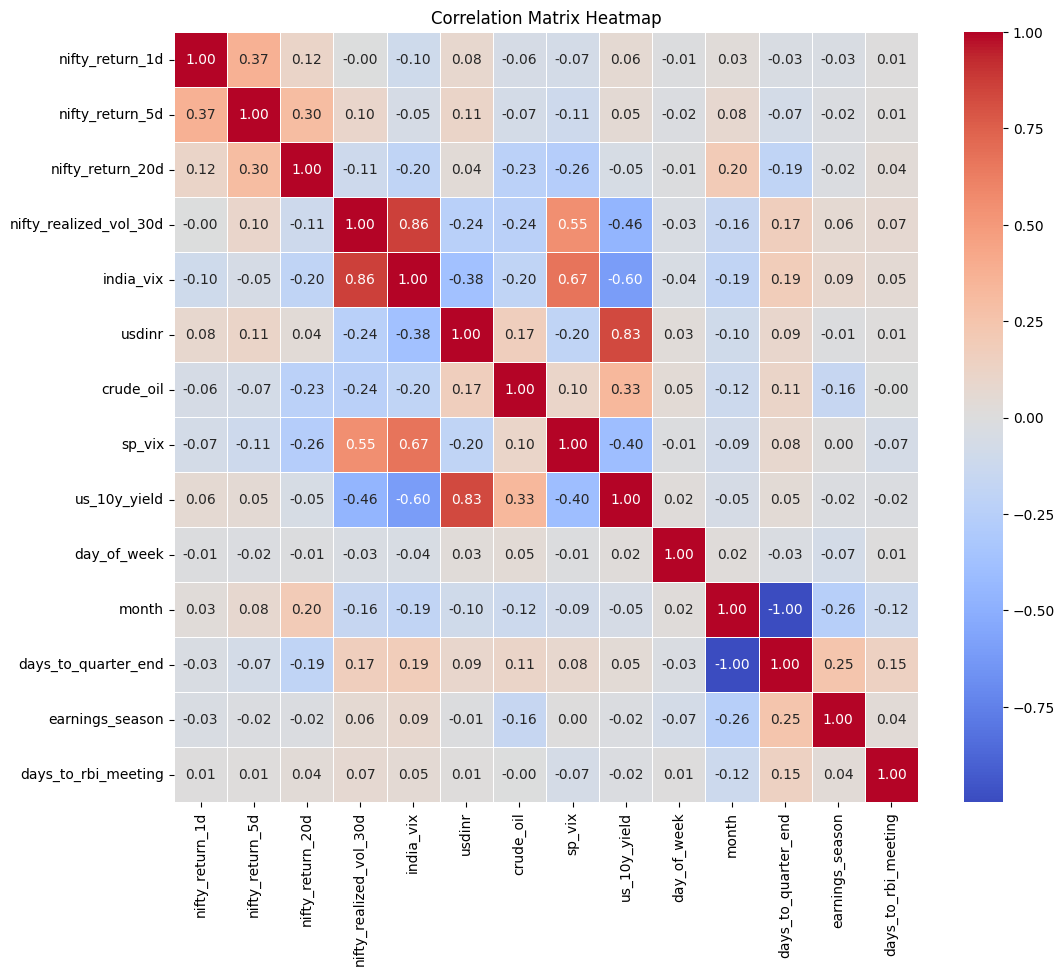

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
import pandas as pd

# Load the CSV file into a DataFrame
df_ind = pd.read_csv('/content/IND_gdelt_events.csv')

# Display the first 5 rows
print("First 5 rows of the DataFrame:")
display(df_ind.head())

# Display information about the DataFrame
print("\nDataFrame Info:")
df_ind.info()

print("Missing values per column:")
print(df_ind.isnull().sum())

df_ind['Event_Date'] = pd.to_datetime(df_ind['Event_Date'])
df_ind.set_index('Event_Date', inplace=True)

print("\nDataFrame Info after processing:")
df_ind.info()

First 5 rows of the DataFrame:


,Event_Date,Country,Demonstrations_Mentions,Hunger_Strikes_Mentions,Strikes_Boycotts_Mentions,Attacks_Mentions,Mass_Violence_Mentions,General_Coerce_Mentions,Seizure_Mentions,Average_Tone,Average_GoldsteinScale,Total_Sources
0,2000-01-02,IND,12,0,0,0,0,7,0,5.228463,-7.666667,9
1,2000-01-03,IND,6,0,0,0,0,4,0,4.735992,-7.375000,4
2,2000-01-04,IND,0,0,0,0,9,13,0,5.518782,-10.000000,3
3,2000-01-05,IND,0,0,0,0,0,18,0,1.812127,-10.000000,2
4,2000-01-06,IND,0,0,0,16,0,6,0,4.554943,-9.400000,5



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8934 entries, 0 to 8933
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Event_Date                 8934 non-null   object 
 1   Country                    8934 non-null   object 
 2   Demonstrations_Mentions    8934 non-null   int64  
 3   Hunger_Strikes_Mentions    8934 non-null   int64  
 4   Strikes_Boycotts_Mentions  8934 non-null   int64  
 5   Attacks_Mentions           8934 non-null   int64  
 6   Mass_Violence_Mentions     8934 non-null   int64  
 7   General_Coerce_Mentions    8934 non-null   int64  
 8   Seizure_Mentions           8934 non-null   int64  
 9   Average_Tone               8934 non-null   float64
 10  Average_GoldsteinScale     8934 non-null   float64
 11  Total_Sources              8934 non-null   int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 837.7+ KB
Missing values per column:
E

In [ ]:
import pandas as pd
import numpy as np

# -----------------------
# Utility functions
# -----------------------

def normalize_series(series):
    """Normalize a pandas Series to 0–1 scale using min–max normalization"""
    min_val, max_val = series.min(), series.max()
    if max_val == min_val:
        return pd.Series(0, index=series.index)
    return (series - min_val) / (max_val - min_val)

# -----------------------
# Core computation
# -----------------------

def calculate_unrest_components(df):
    """
    Compute unrest subcomponents as in the yearly index methodology,
    scaled by media coverage.
    Assumes df has columns:
    ['Demonstrations_Mentions','Hunger_Strikes_Mentions','Strikes_Boycotts_Mentions',
     'Attacks_Mentions','Mass_Violence_Mentions','General_Coerce_Mentions','Seizure_Mentions',
     'Average_GoldsteinScale','Average_Tone','Total_Sources']
    and Event_Date is the index.
    """
    df = df.copy()

    df['Total_Sources_log'] = np.log1p(df['Total_Sources'])

    # Protest-related actions (non-violent)
    df['protest_intensity'] = (
        df['Demonstrations_Mentions'] +
        df['Hunger_Strikes_Mentions'] +
        df['Strikes_Boycotts_Mentions']
    ) * df['Total_Sources_log']

    # Violence-related actions (more severe)
    df['violence_intensity'] = (
        df['Attacks_Mentions'] +
        df['Mass_Violence_Mentions'] +
        df['General_Coerce_Mentions'] +
        df['Seizure_Mentions']
    ) * df['Total_Sources']

    # Conflict score (Goldstein: negative = conflict)
    df['conflict_score'] = (-df['Average_GoldsteinScale'] + 10) * df['Total_Sources']

    # Negative tone (scaled by sources)
    df['scaled_tone'] = -df['Average_Tone'] * df['Total_Sources']

    return df


def compute_unrest_index(df, window, label):
    """
    Rolling-sum and normalize each component to create an unrest index
    over the given window length in days.
    """
    rolled = df[['protest_intensity', 'violence_intensity',
                 'conflict_score', 'scaled_tone', 'Total_Sources']].rolling(window=window, min_periods=1).sum()

    # Normalize each subcomponent
    rolled['protests_norm'] = normalize_series(rolled['protest_intensity'])
    rolled['violence_norm'] = normalize_series(rolled['violence_intensity'])
    rolled['conflict_norm'] = normalize_series(rolled['conflict_score'])
    rolled['tone_norm'] = normalize_series(rolled['scaled_tone'])

    # Equal-weight composite unrest index (0.25 each)
    rolled[f'unrest_index_{label}'] = (
        0.25 * rolled['protests_norm'] +
        0.25 * rolled['violence_norm'] +
        0.25 * rolled['conflict_norm'] +
        0.25 * rolled['tone_norm']
    )

    # Normalized media coverage indicator
    rolled[f'source_coverage_{label}'] = normalize_series(rolled['Total_Sources'])

    return rolled[[f'unrest_index_{label}', f'source_coverage_{label}']]


def create_multiscale_rsui(df):
    """
    Compute 7-day, 30-day, 90-day (quarterly), and 365-day (yearly)
    unrest indices from daily-level df with Event_Date as index.
    """
    # Ensure datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("df index must be a DatetimeIndex of Event_Date")

    df = calculate_unrest_components(df)

    # Compute indices for all scales
    idx_7d = compute_unrest_index(df, window=7, label='7d')
    idx_30d = compute_unrest_index(df, window=30, label='30d')
    idx_quarter = compute_unrest_index(df, window=90, label='quarterly')
    idx_year = compute_unrest_index(df, window=365, label='yearly')

    # Combine all into one dataframe (indexed by Event_Date)
    rsui_multi = pd.concat([idx_7d, idx_30d, idx_quarter, idx_year], axis=1)

    return rsui_multi

# -----------------------
# Example usage
# -----------------------

# Suppose df_ind already exists with Event_Date as the index
# (make sure index is sorted chronologically)
df_ind = df_ind.sort_index()

# Compute 7d, 30d, quarterly, yearly RSUI-style indices
rsui_multi = create_multiscale_rsui(df_ind)

# Save for further analysis
rsui_multi.to_csv("RSUI_multiscale_from_index.csv")

print(" Created 7-day, 30-day, quarterly, and yearly RSUI-weighted indices (Event_Date as index).")
print(rsui_multi.head())

 Created 7-day, 30-day, quarterly, and yearly RSUI-weighted indices (Event_Date as index).
            unrest_index_7d  source_coverage_7d  unrest_index_30d  \
Event_Date                                                          
2000-01-02         0.040562            0.000121          0.034068   
2000-01-03         0.040618            0.000607          0.034091   
2000-01-04         0.040656            0.000970          0.034107   
2000-01-05         0.040712            0.001213          0.034133   
2000-01-06         0.040790            0.001820          0.034166   

            source_coverage_30d  unrest_index_quarterly  \
Event_Date                                                
2000-01-02             0.000000                0.035164   
2000-01-03             0.000236                0.035176   
2000-01-04             0.000413                0.035183   
2000-01-05             0.000531                0.035196   
2000-01-06             0.000826                0.035212   

           

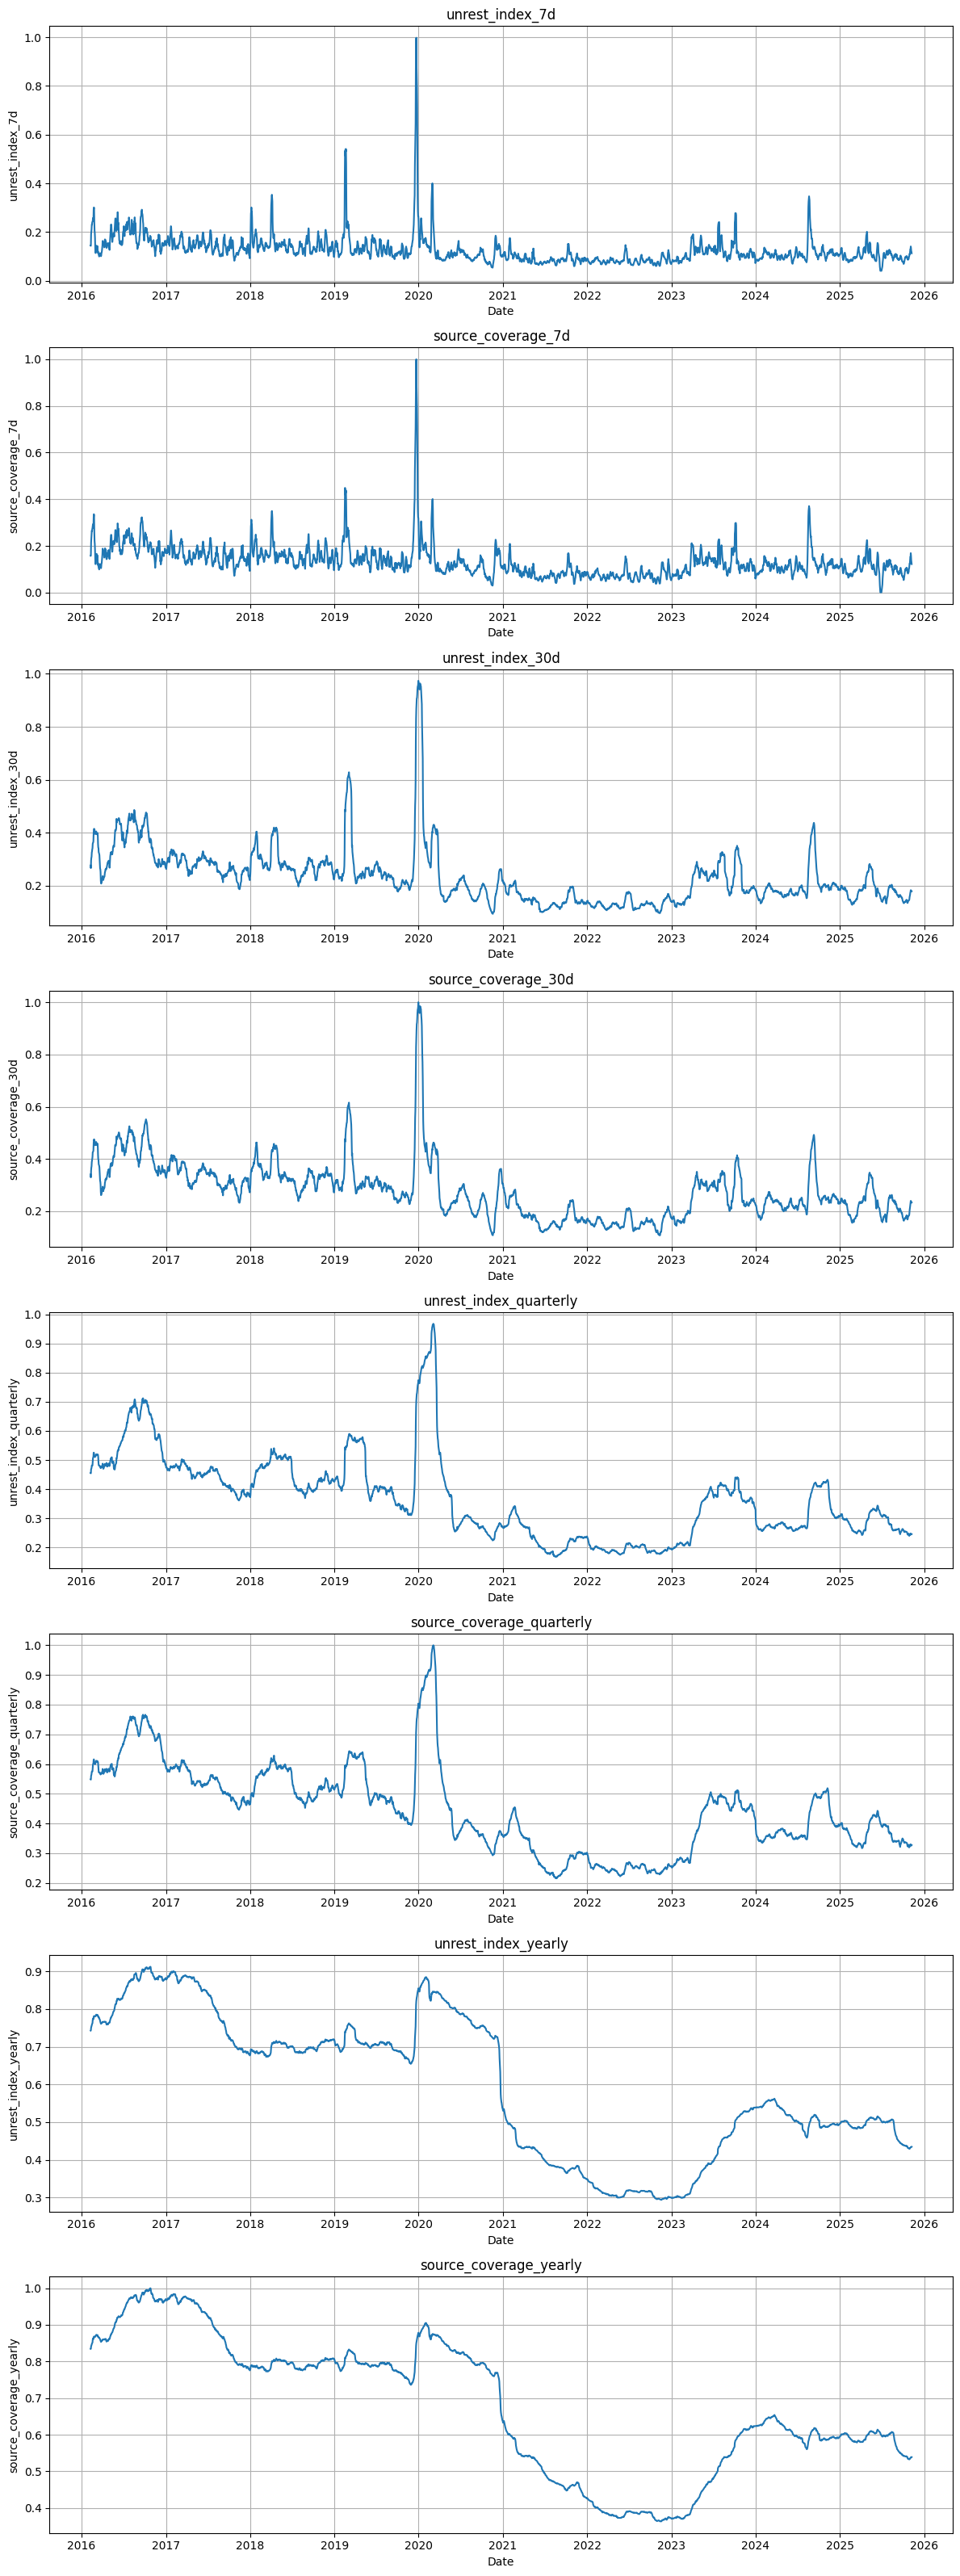

In [ ]:
rsui_multi = rsui_multi.loc[rsui_multi.index >= '2016-02-09']
import matplotlib.pyplot as plt

# Plot all columns of rsui_multi against the date
fig, axes = plt.subplots(nrows=len(rsui_multi.columns), figsize=(12, 4 * len(rsui_multi.columns)))

for i, col in enumerate(rsui_multi.columns):
    axes[i].plot(rsui_multi.index, rsui_multi[col])
    axes[i].set_title(col)
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel(col)
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Drop columns starting with 'source_coverage_'
columns_to_drop = [col for col in rsui_multi.columns if col.startswith('source_coverage_')]
rsui_multi = rsui_multi.drop(columns=columns_to_drop)

print("Columns remaining in rsui_multi after dropping source_coverage columns:")
print(rsui_multi.columns)

Columns remaining in rsui_multi after dropping source_coverage columns:
Index(['unrest_index_7d', 'unrest_index_30d', 'unrest_index_quarterly',
       'unrest_index_yearly'],
      dtype='object')


In [ ]:
import pandas as pd
import numpy as np

rsui_multi_indicators = rsui_multi.copy()

# Create indicator variables for all numeric columns
for col in rsui_multi.select_dtypes(include=[np.number]).columns:
    p95 = np.nanpercentile(rsui_multi[col], 95)
    rsui_multi_indicators[f'{col}_above95'] = (rsui_multi[col] > p95).astype(int)

# Save or preview the result
rsui_multi_indicators.to_csv("RSUI_multiscale_with_95th_indicators.csv")

print(" Added 95th percentile indicator variables for each RSUI column.")
print(rsui_multi_indicators.head())

 Added 95th percentile indicator variables for each RSUI column.
            unrest_index_7d  unrest_index_30d  unrest_index_quarterly  \
Event_Date                                                              
2016-02-09         0.144696          0.276732                0.455229   
2016-02-10         0.144041          0.266838                0.454536   
2016-02-11         0.192202          0.296178                0.468911   
2016-02-12         0.203053          0.305366                0.470287   
2016-02-13         0.211624          0.309414                0.473541   

            unrest_index_yearly  unrest_index_7d_above95  \
Event_Date                                                 
2016-02-09             0.742561                        0   
2016-02-10             0.743259                        0   
2016-02-11             0.750346                        0   
2016-02-12             0.752806                        0   
2016-02-13             0.754617                        0   

  

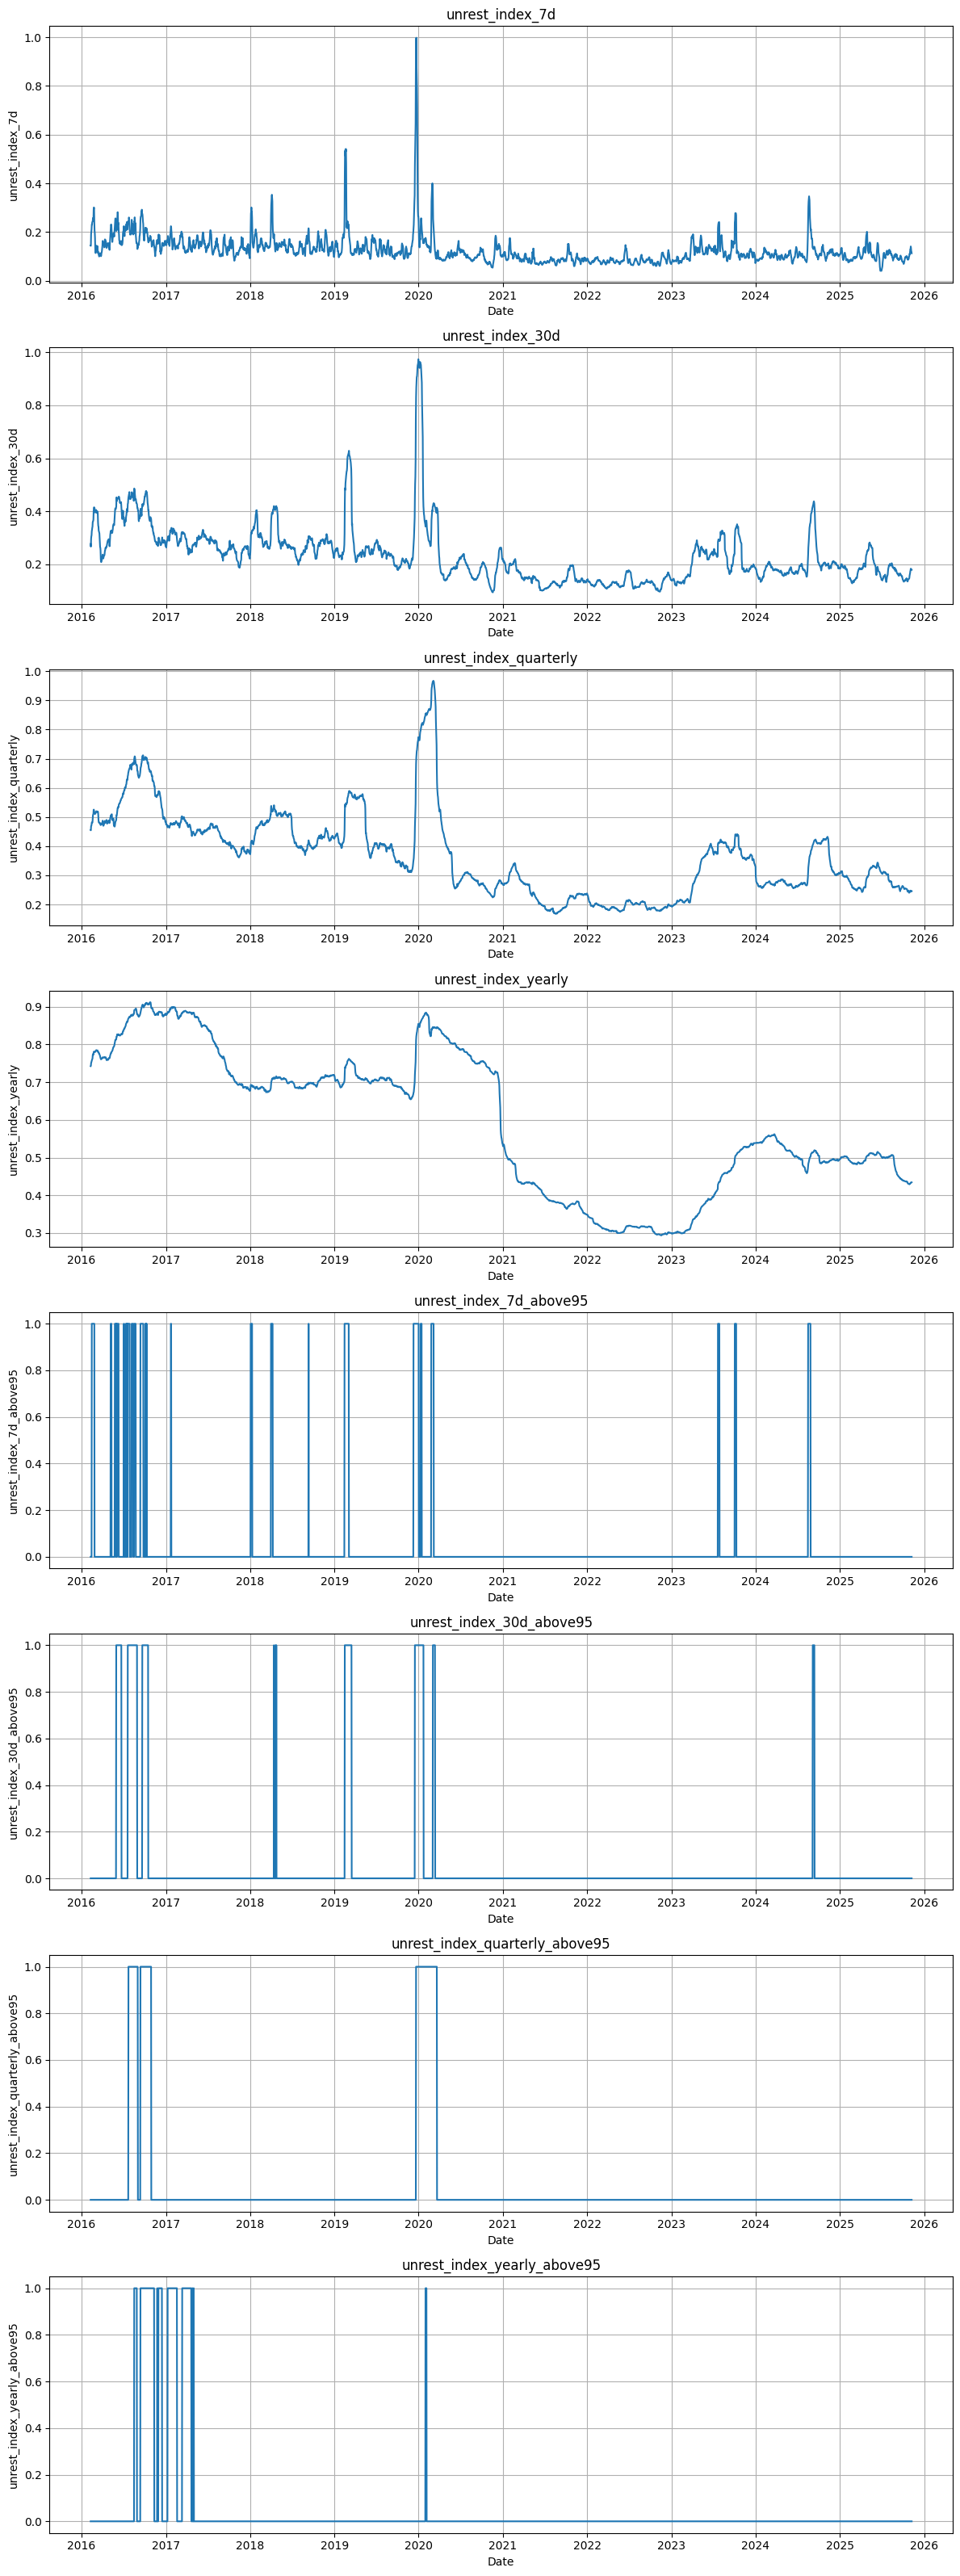

In [ ]:
import matplotlib.pyplot as plt

# Plot all columns of rsui_multi against the date
fig, axes = plt.subplots(nrows=len(rsui_multi_indicators.columns), figsize=(12, 4 * len(rsui_multi_indicators.columns)))

for i, col in enumerate(rsui_multi_indicators.columns):
    axes[i].plot(rsui_multi_indicators.index, rsui_multi_indicators[col])
    axes[i].set_title(col)
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel(col)
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
conditioning_df = pd.read_csv("conditioning_variables_raw.csv", index_col='Unnamed: 0')
conditioning_df.head()

,nifty_return_1d,nifty_return_5d,nifty_return_20d,nifty_realized_vol_30d,india_vix,usdinr,crude_oil,sp_vix,us_10y_yield,day_of_week,month,days_to_quarter_end,earnings_season,days_to_rbi_meeting
2016-02-09,-0.012055,-0.021105,-0.035121,0.170519,21.73,68.075996,30.320000,26.540001,1.729,1,2,416,1,0
2016-07-20,0.004374,0.005440,0.042087,0.119542,15.99,67.206001,47.169998,11.770000,1.580,2,7,254,1,19
2017-08-10,-0.008861,-0.019314,-0.007223,0.084969,13.80,63.887699,51.900002,16.040001,2.212,3,8,233,1,0
2017-08-14,0.008583,-0.026175,-0.012283,0.090983,14.38,64.081001,50.730000,12.330000,2.219,0,8,229,1,0
2017-09-14,0.000724,0.015781,0.019126,0.105283,11.47,64.115097,55.470001,10.440000,2.197,3,9,198,0,24


In [ ]:
import pandas as pd
import numpy as np

# --- Standardize datetime index for conditioning_df ---
if 'Event_Date' in conditioning_df.columns:
    conditioning_df['Event_Date'] = pd.to_datetime(conditioning_df['Event_Date']).dt.normalize()
    conditioning_df.set_index('Event_Date', inplace=True)
else:
    conditioning_df.index = pd.to_datetime(conditioning_df.index).to_series().dt.normalize()

# --- Standardize datetime index for rsui_multi_indicators ---
if 'Event_Date' in rsui_multi_indicators.columns:
    rsui_multi_indicators['Event_Date'] = pd.to_datetime(rsui_multi_indicators['Event_Date']).dt.normalize()
    rsui_multi_indicators.set_index('Event_Date', inplace=True)
else:
    rsui_multi_indicators.index = pd.to_datetime(rsui_multi_indicators.index).to_series().dt.normalize()

# --- Step 1: Clean & align indices ---
conditioning_df = conditioning_df.sort_index()
rsui_multi_indicators = rsui_multi_indicators.sort_index()
conditioning_df = conditioning_df[~conditioning_df.index.duplicated(keep='first')]
rsui_multi_indicators = rsui_multi_indicators[~rsui_multi_indicators.index.duplicated(keep='first')]

# --- Step 2: Identify missing dates in rsui_multi_indicators ---
missing_dates = conditioning_df.index.difference(rsui_multi_indicators.index)

# --- Step 3: Extend rsui_multi_indicators to include missing dates ---
# Reindex to conditioning_df index and fill missing values by previous valid value
rsui_extended = rsui_multi_indicators.reindex(conditioning_df.index)
rsui_extended = rsui_extended.ffill()  # forward-fill from previous date

# --- Step 4: Combine both datasets (only conditioning_df’s dates retained) ---
merged_df = pd.concat([conditioning_df, rsui_extended], axis=1)

# --- Step 5: Save the merged dataframe ---
merged_df.to_csv("merged_conditioning_rsui_ffill.csv")

print(" Merged dataset created using forward-fill for missing RSUI dates.")
print(f"Conditioning variables shape: {conditioning_df.shape}")
print(f"RSUI indicators shape: {rsui_multi_indicators.shape}")
print(f"Merged shape: {merged_df.shape}")
print("\nDates range:", merged_df.index.min(), "to", merged_df.index.max())
print("\nSample preview:")
print(merged_df.head(10))

 Merged dataset created using forward-fill for missing RSUI dates.
Conditioning variables shape: (500, 14)
RSUI indicators shape: (3545, 8)
Merged shape: (500, 22)

Dates range: 2016-02-09 00:00:00 to 2025-06-27 00:00:00

Sample preview:
            nifty_return_1d  nifty_return_5d  nifty_return_20d  \
2016-02-09        -0.012055        -0.021105         -0.035121   
2016-07-20         0.004374         0.005440          0.042087   
2017-08-10        -0.008861        -0.019314         -0.007223   
2017-08-14         0.008583        -0.026175         -0.012283   
2017-09-14         0.000724         0.015781          0.019126   
2017-11-14        -0.003751        -0.015802         -0.004325   
2017-12-04         0.000588        -0.026136         -0.031004   
2017-12-06        -0.007328        -0.030614         -0.025143   
2017-12-18         0.005371         0.006442          0.008739   
2017-12-20        -0.001816         0.024649          0.009853   

            nifty_realized_vol_30d 

In [ ]:
merged_df.columns

Index(['nifty_return_1d', 'nifty_return_5d', 'nifty_return_20d',
       'nifty_realized_vol_30d', 'india_vix', 'usdinr', 'crude_oil', 'sp_vix',
       'us_10y_yield', 'day_of_week', 'month', 'days_to_quarter_end',
       'earnings_season', 'days_to_rbi_meeting', 'unrest_index_7d',
       'unrest_index_30d', 'unrest_index_quarterly', 'unrest_index_yearly',
       'unrest_index_7d_above95', 'unrest_index_30d_above95',
       'unrest_index_quarterly_above95', 'unrest_index_yearly_above95'],
      dtype='object')

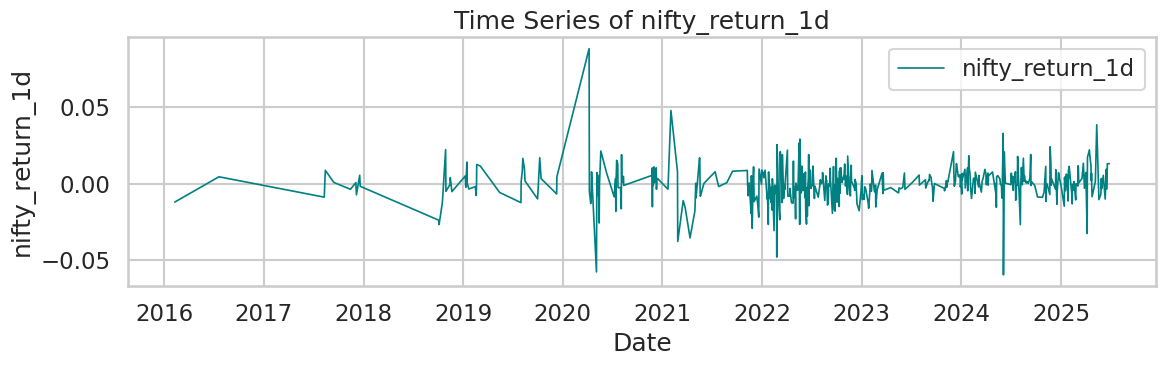

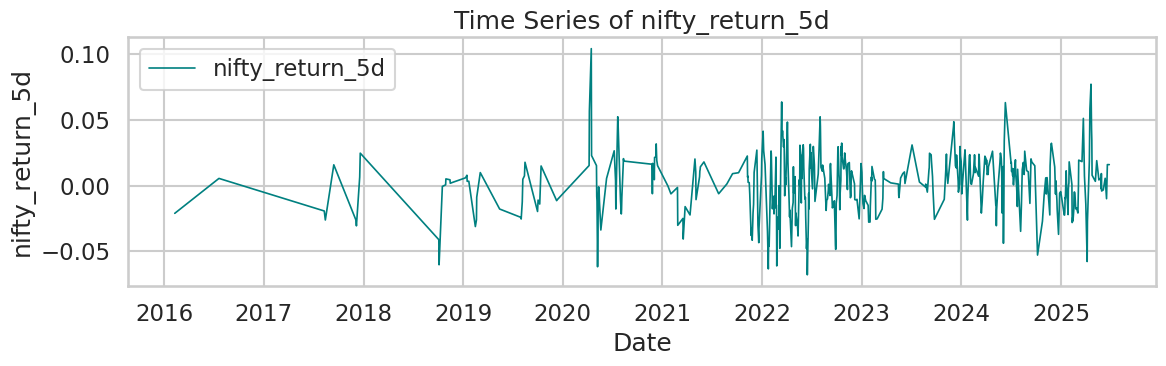

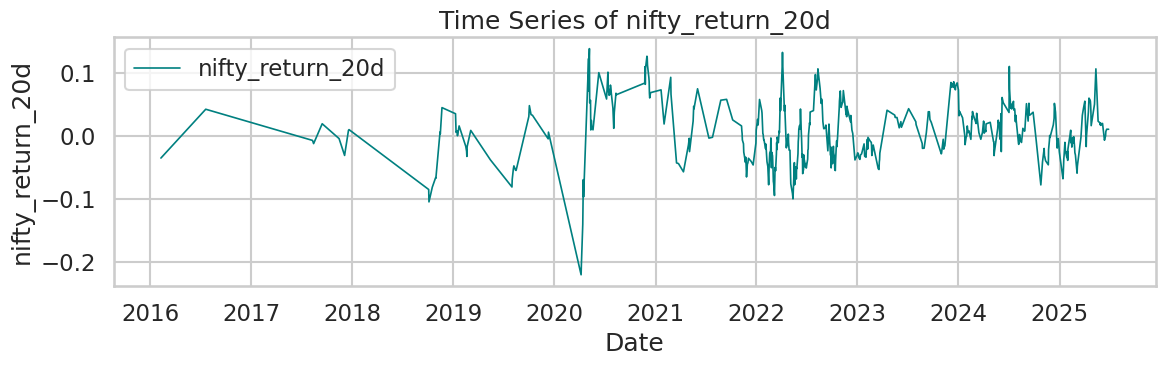

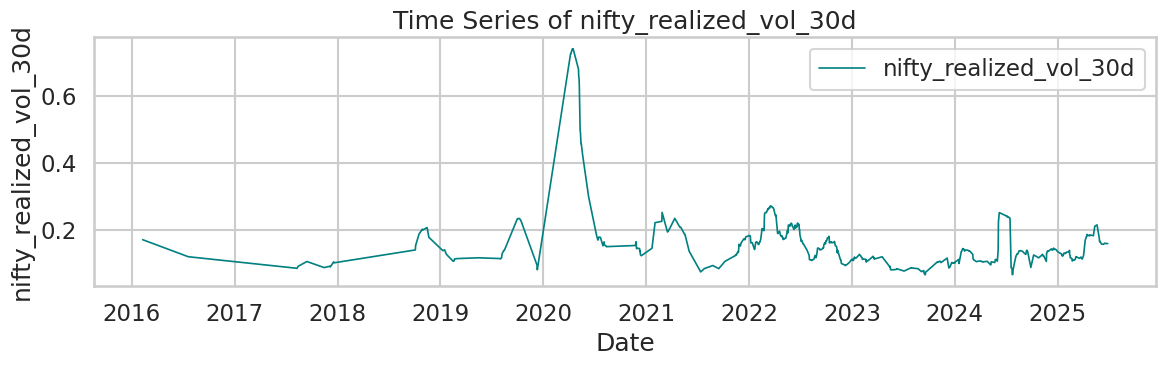

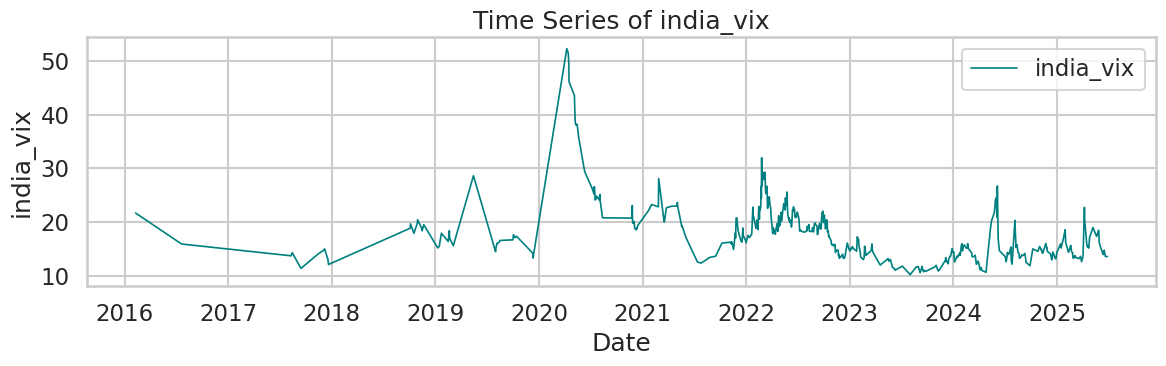

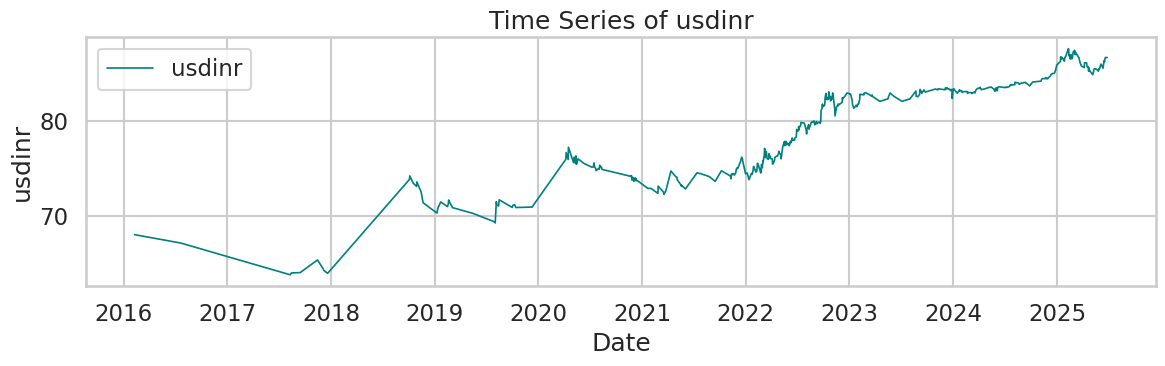

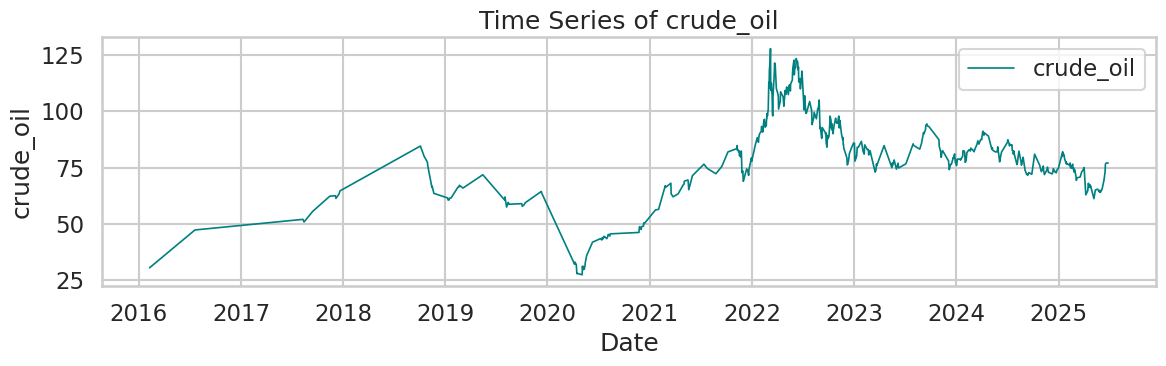

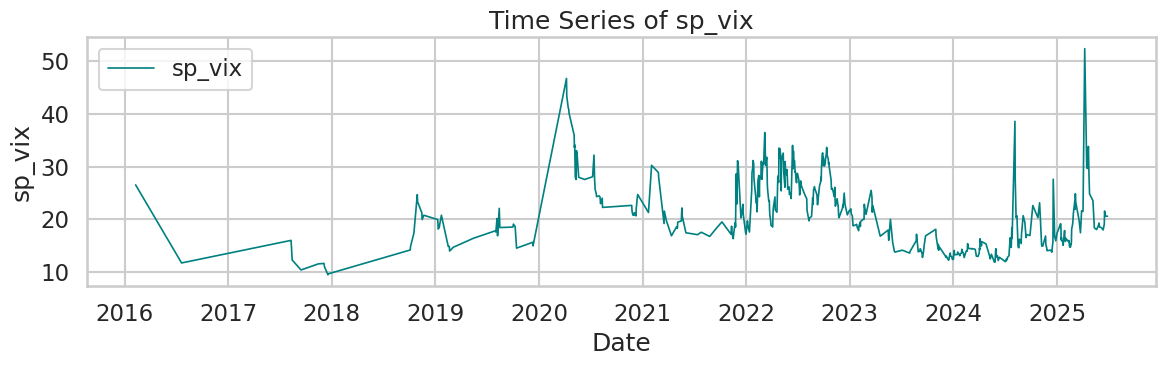

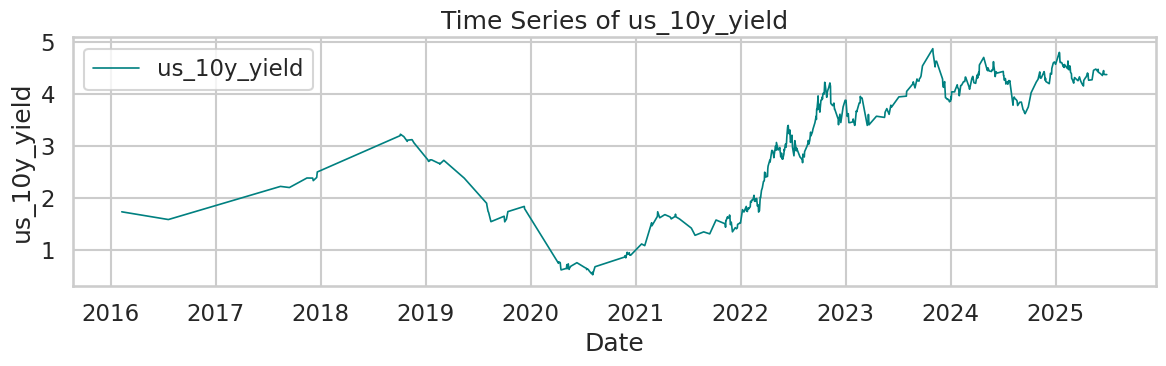

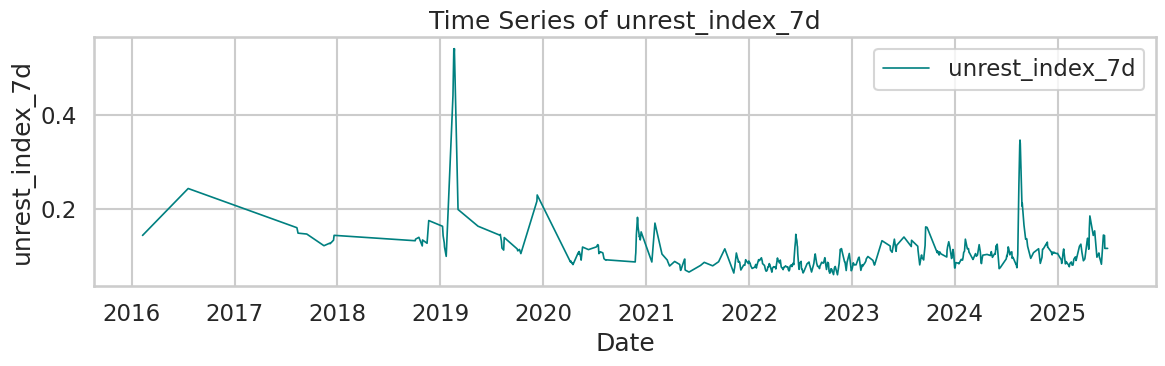

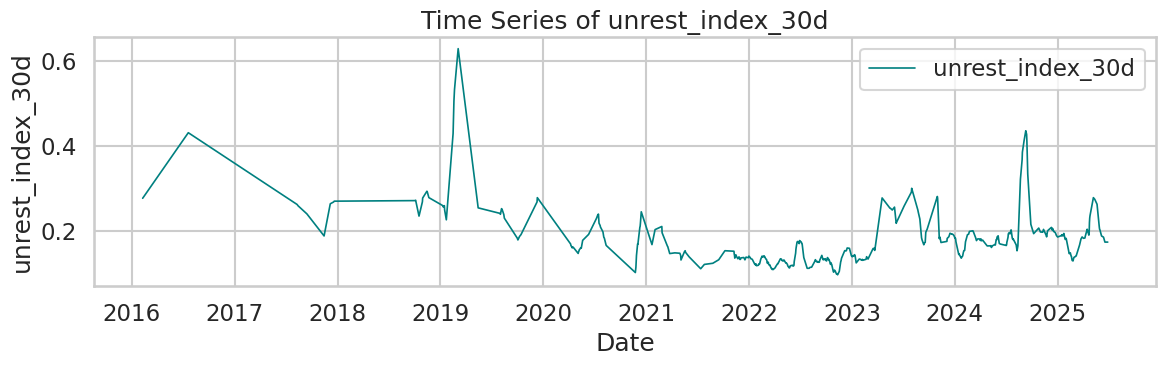

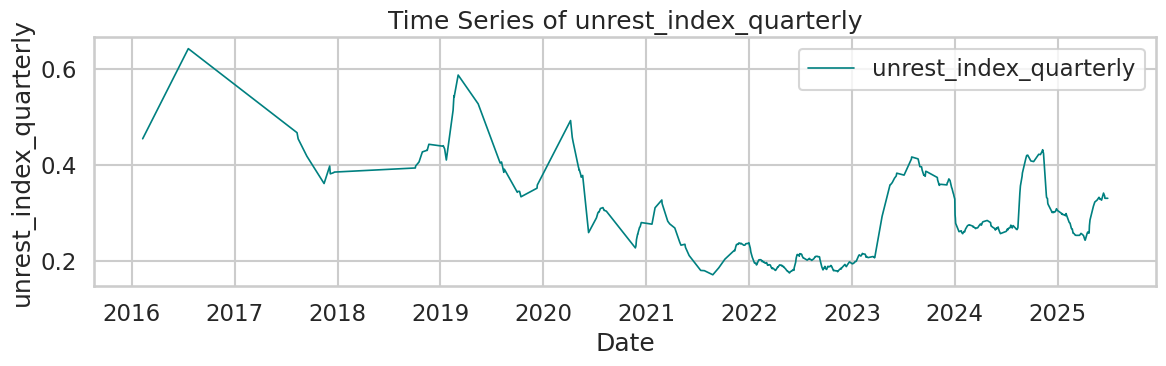

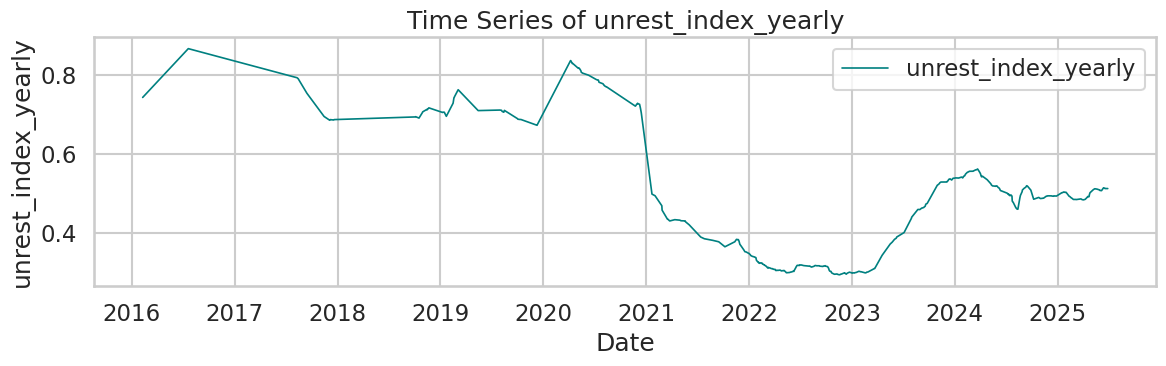

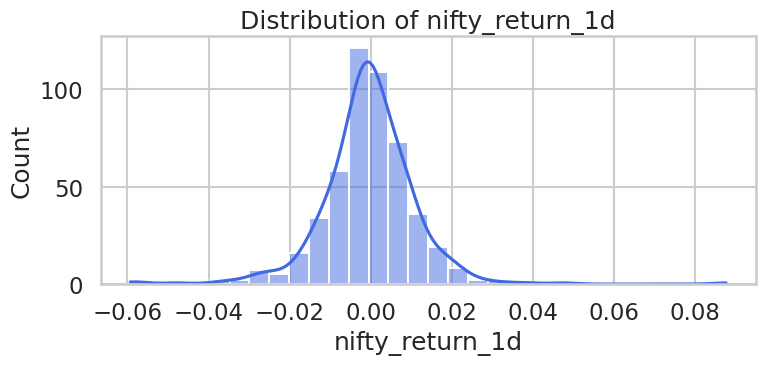

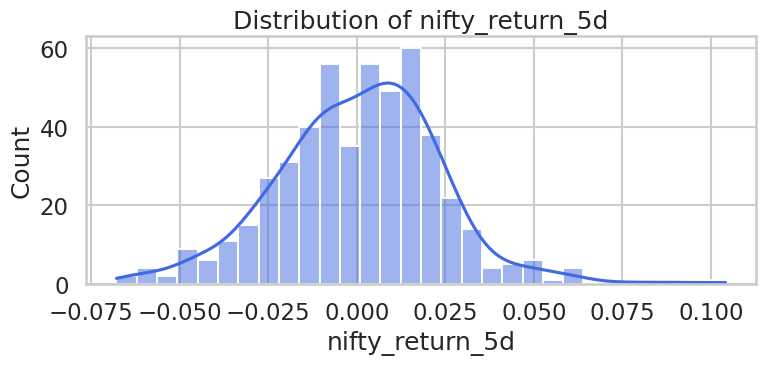

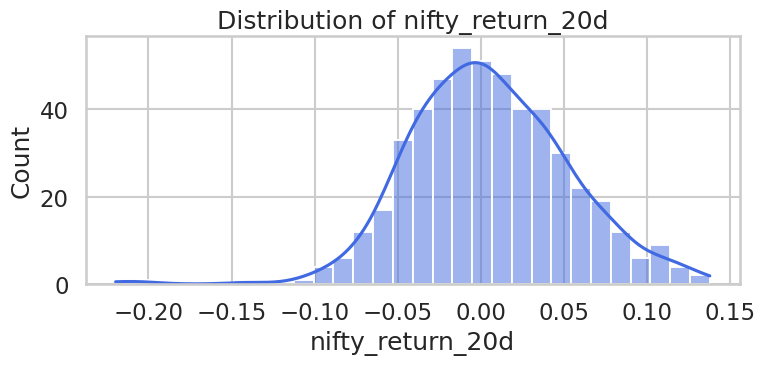

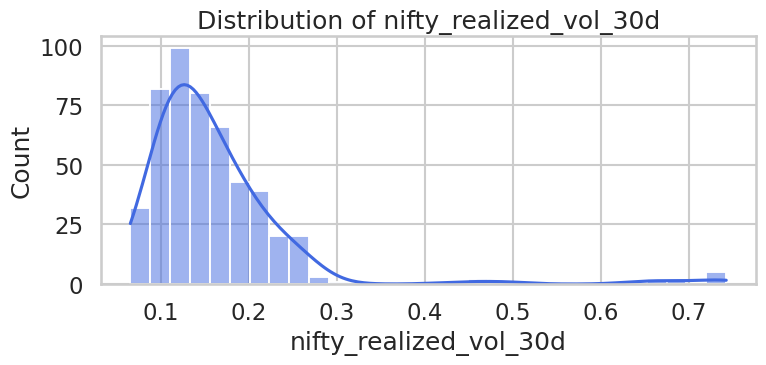

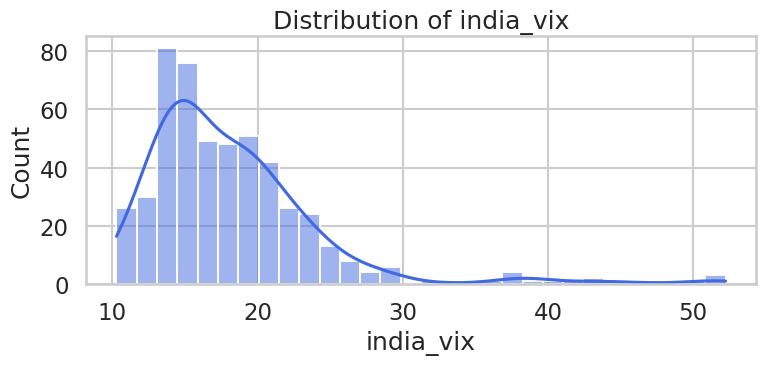

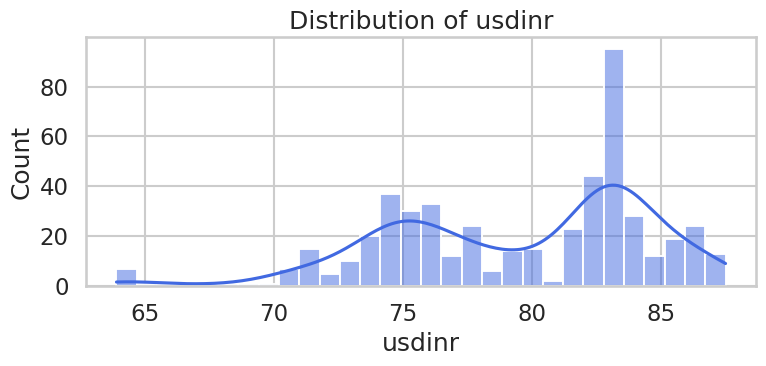

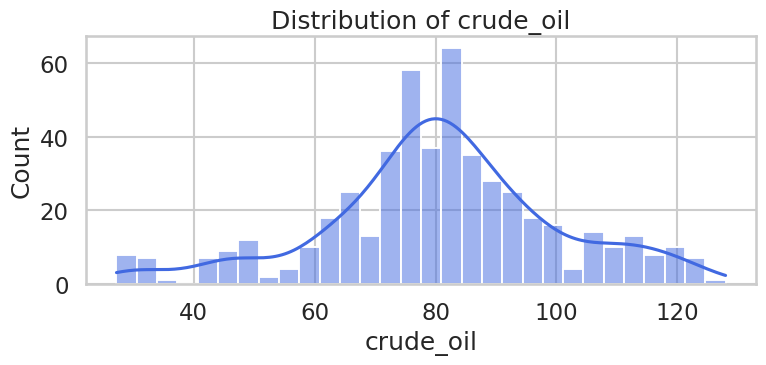

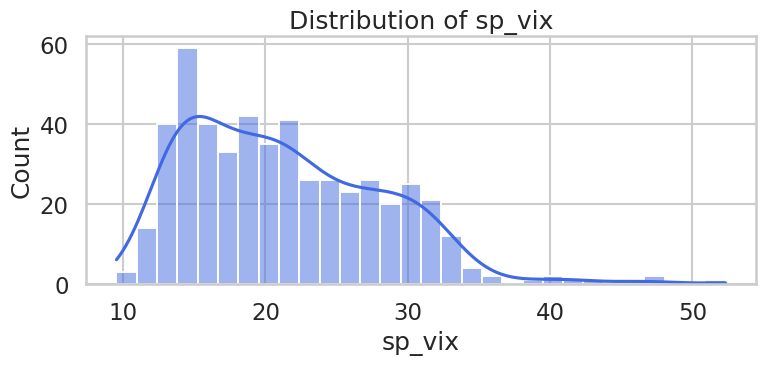

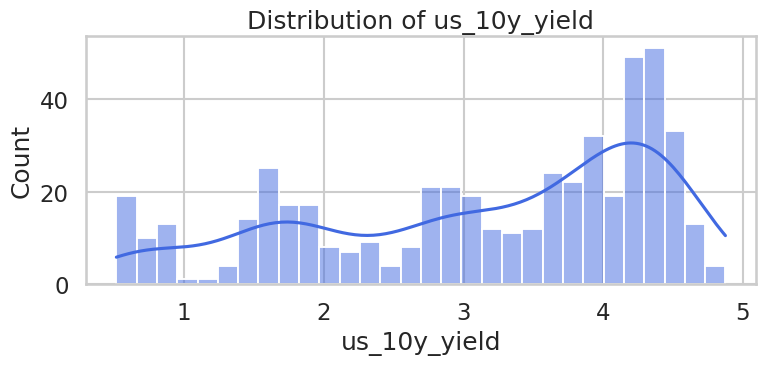

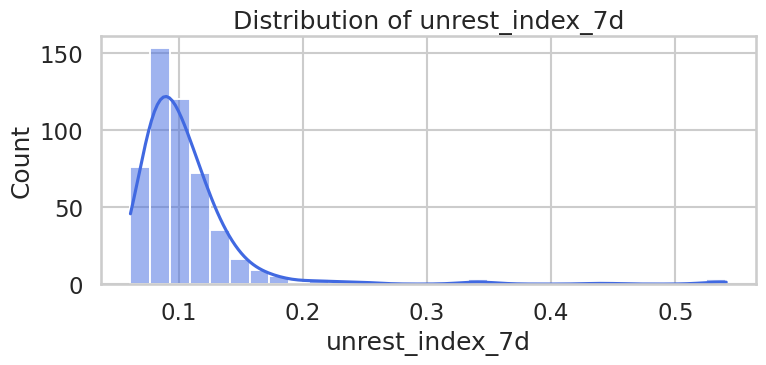

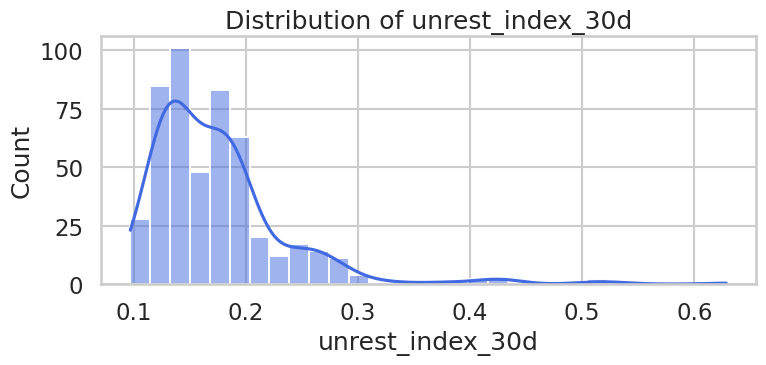

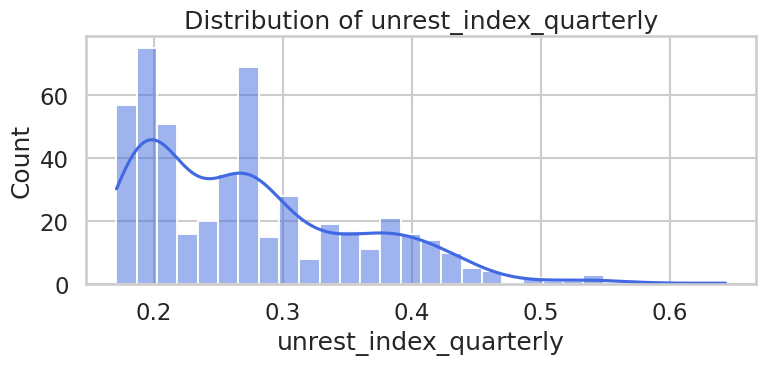

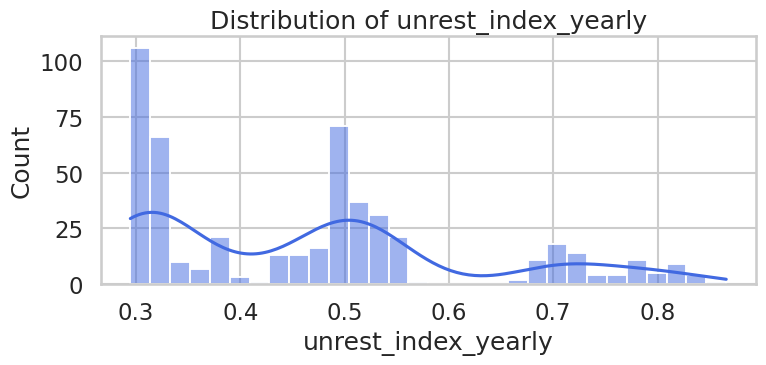

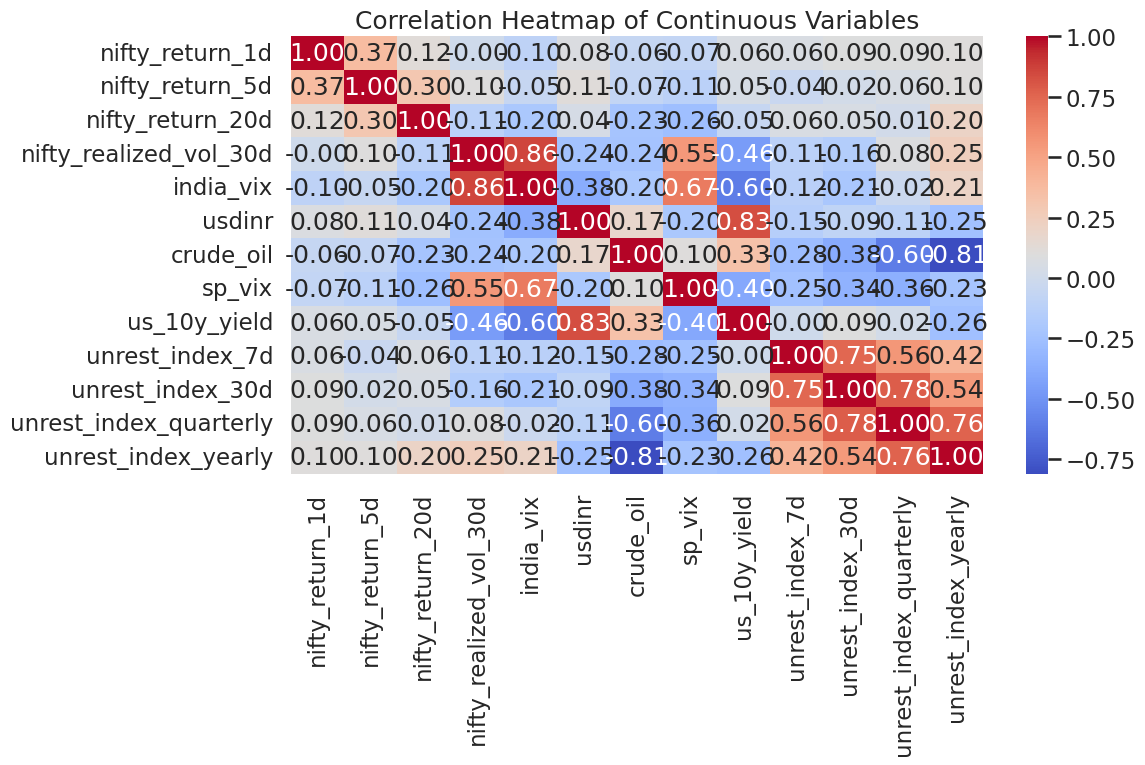

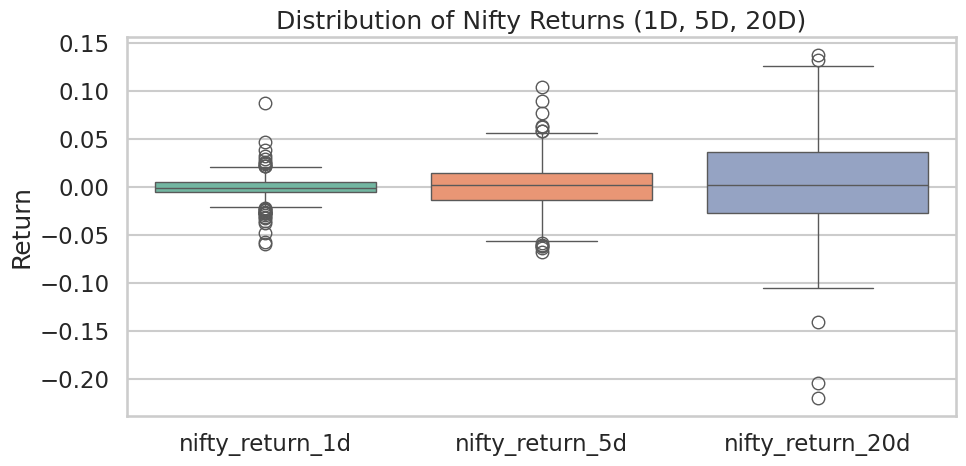

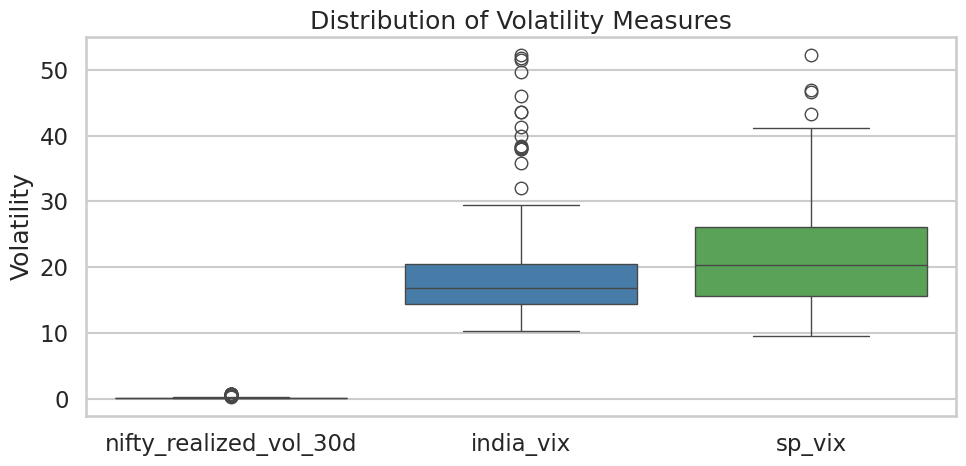

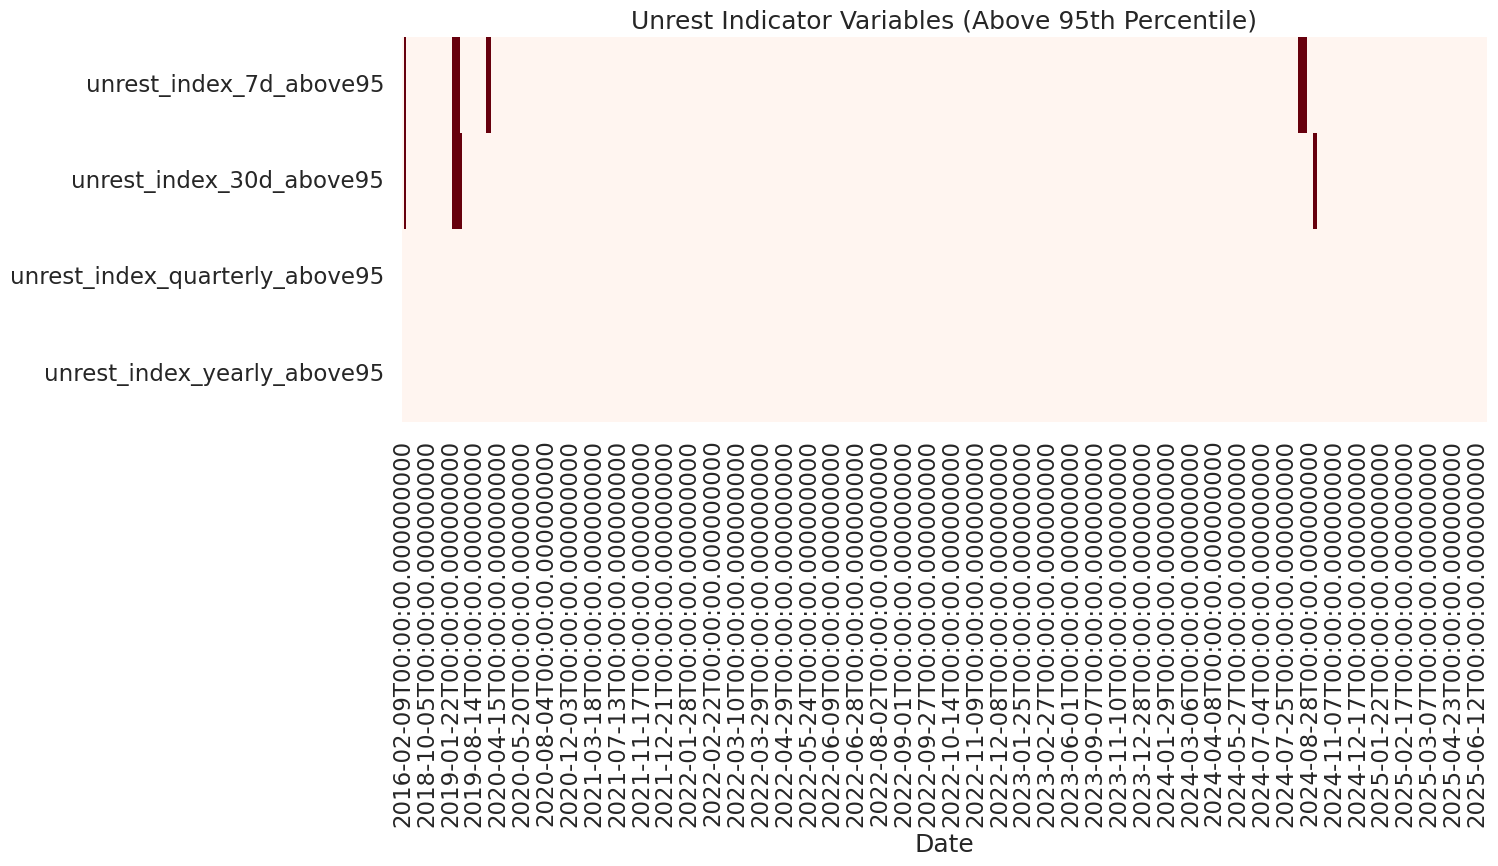

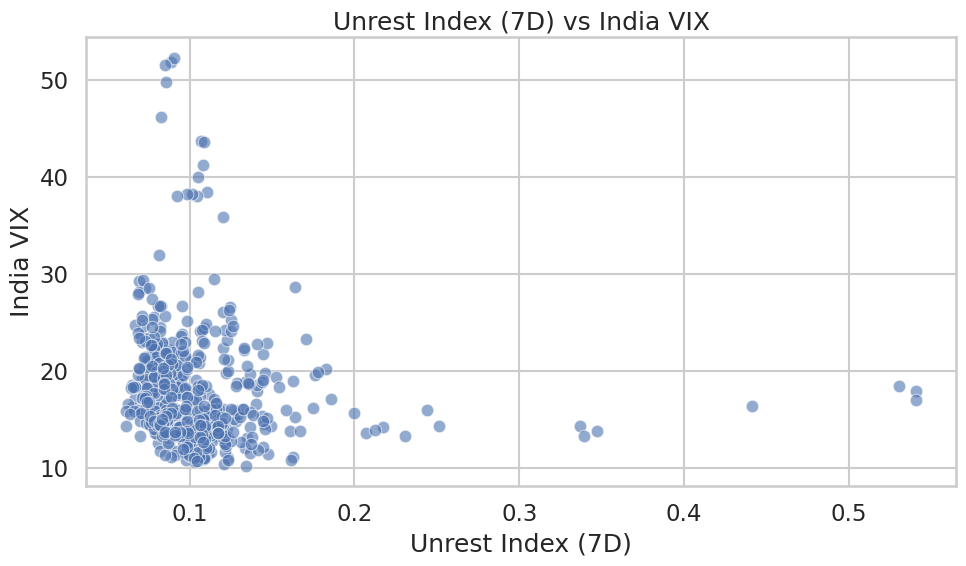

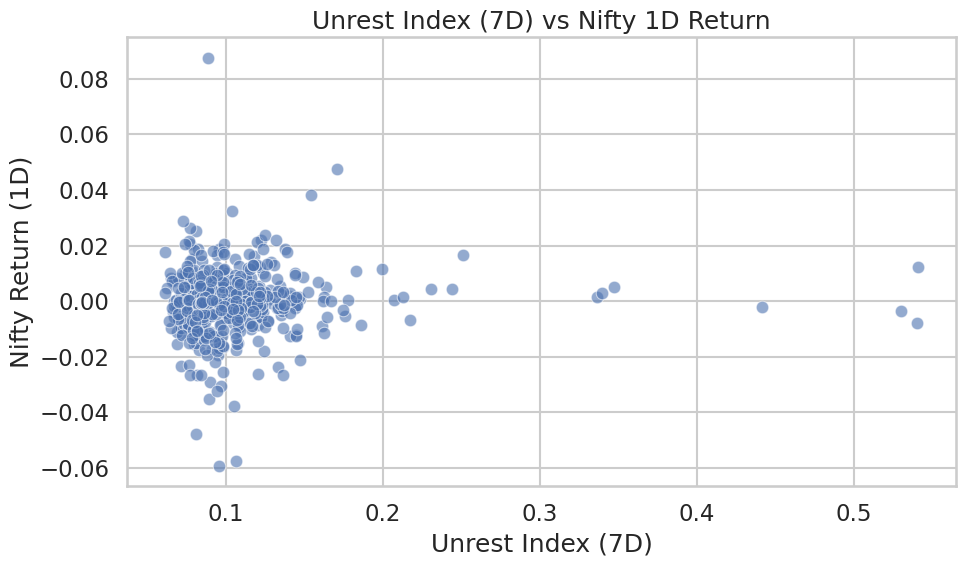

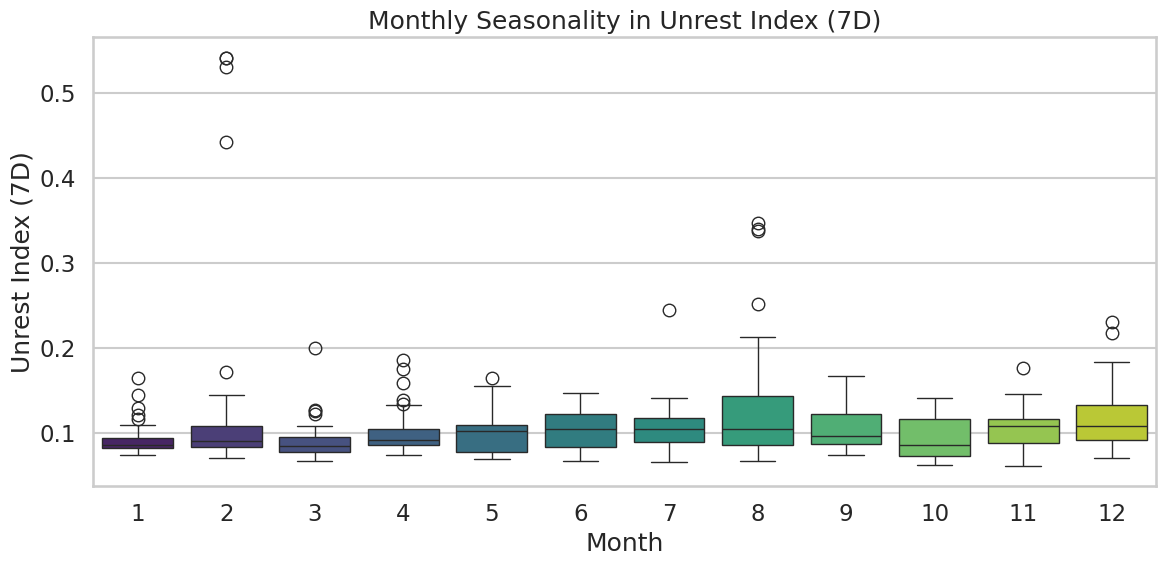

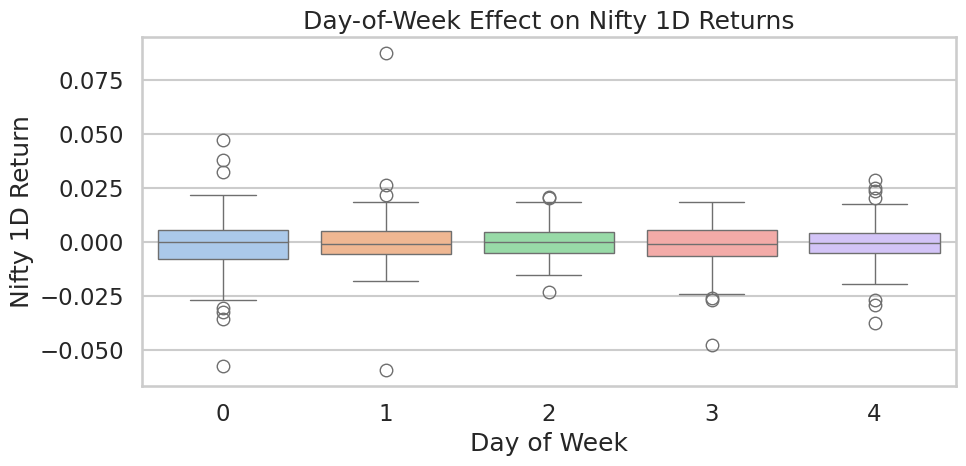

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Ensure DataFrame is loaded ---
# merged_df = pd.read_csv("merged_conditioning_rsui_ffill.csv", index_col='Event_Date', parse_dates=True)

# --- Sort chronologically ---
merged_df = merged_df.sort_index()

# --- Plot aesthetics ---
sns.set(style="whitegrid", context="talk")

# --- 1. Time Series Plots for Key Continuous Variables ---
continuous_vars = [
    'nifty_return_1d', 'nifty_return_5d', 'nifty_return_20d',
    'nifty_realized_vol_30d', 'india_vix', 'usdinr', 'crude_oil',
    'sp_vix', 'us_10y_yield', 'unrest_index_7d', 'unrest_index_30d',
    'unrest_index_quarterly', 'unrest_index_yearly'
]

for col in continuous_vars:
    plt.figure(figsize=(12, 4))
    plt.plot(merged_df.index, merged_df[col], label=col, color='teal', linewidth=1.2)
    plt.title(f"Time Series of {col}")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- 2. Distribution Histograms ---
for col in continuous_vars:
    plt.figure(figsize=(8, 4))
    sns.histplot(merged_df[col], kde=True, bins=30, color='royalblue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

# --- 3. Correlation Heatmap ---
plt.figure(figsize=(12, 8))
corr = merged_df[continuous_vars].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Continuous Variables")
plt.tight_layout()
plt.show()

# --- 4. Boxplots: Returns and Volatility ---
plt.figure(figsize=(10, 5))
sns.boxplot(data=merged_df[['nifty_return_1d', 'nifty_return_5d', 'nifty_return_20d']], palette='Set2')
plt.title("Distribution of Nifty Returns (1D, 5D, 20D)")
plt.ylabel("Return")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=merged_df[['nifty_realized_vol_30d', 'india_vix', 'sp_vix']], palette='Set1')
plt.title("Distribution of Volatility Measures")
plt.ylabel("Volatility")
plt.tight_layout()
plt.show()

# --- 5. Indicator Variable Heatmap ---
indicator_vars = [
    'unrest_index_7d_above95', 'unrest_index_30d_above95',
    'unrest_index_quarterly_above95', 'unrest_index_yearly_above95'
]

plt.figure(figsize=(14, 5))
sns.heatmap(merged_df[indicator_vars].T, cmap='Reds', cbar=False)
plt.title("Unrest Indicator Variables (Above 95th Percentile)")
plt.yticks(rotation=0)
plt.xlabel("Date")
plt.tight_layout()
plt.show()

# --- 6. Unrest vs Volatility ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x=merged_df['unrest_index_7d'], y=merged_df['india_vix'], alpha=0.6)
plt.title("Unrest Index (7D) vs India VIX")
plt.xlabel("Unrest Index (7D)")
plt.ylabel("India VIX")
plt.tight_layout()
plt.show()

# --- 7. Unrest vs Market Return ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x=merged_df['unrest_index_7d'], y=merged_df['nifty_return_1d'], alpha=0.6)
plt.title("Unrest Index (7D) vs Nifty 1D Return")
plt.xlabel("Unrest Index (7D)")
plt.ylabel("Nifty Return (1D)")
plt.tight_layout()
plt.show()

# --- 8. Seasonality: Month and Day-of-Week ---
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='unrest_index_7d', data=merged_df, palette='viridis')
plt.title("Monthly Seasonality in Unrest Index (7D)")
plt.xlabel("Month")
plt.ylabel("Unrest Index (7D)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x='day_of_week', y='nifty_return_1d', data=merged_df, palette='pastel')
plt.title("Day-of-Week Effect on Nifty 1D Returns")
plt.xlabel("Day of Week")
plt.ylabel("Nifty 1D Return")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from scipy.stats import zscore

# --- Ensure datetime index is clean ---
merged_df.index = pd.to_datetime(merged_df.index).normalize()
merged_df = merged_df.sort_index()

# --- Identify indicator (binary) columns ---
indicator_cols = [
    'unrest_index_7d_above95',
    'unrest_index_30d_above95',
    'unrest_index_quarterly_above95',
    'unrest_index_yearly_above95'
]

# --- Select columns to normalize ---
cols_to_normalize = [
    col for col in merged_df.columns
    if col not in indicator_cols
]

# --- Apply z-score normalization only to those columns ---
normalized_df = merged_df.copy()
normalized_df[cols_to_normalize] = merged_df[cols_to_normalize].apply(
    lambda x: (x - x.mean()) / x.std()
)

# --- Optional: verify means ~0 and std ~1 ---
check_stats = normalized_df[cols_to_normalize].agg(['mean', 'std']).T.head(100)
print(" Normalization check (first 10 variables):")
print(check_stats)

# --- Save the normalized dataset ---
normalized_df.to_csv("merged_df_normalized_zscore.csv")
print("\n Normalized dataset saved as 'merged_df_normalized_zscore.csv'")

 Normalization check (first 10 variables):
                                mean  std
nifty_return_1d        -4.263256e-17  1.0
nifty_return_5d         0.000000e+00  1.0
nifty_return_20d       -1.421085e-17  1.0
nifty_realized_vol_30d  1.136868e-16  1.0
india_vix               2.842171e-16  1.0
usdinr                  4.547474e-16  1.0
crude_oil               2.486900e-16  1.0
sp_vix                 -1.136868e-16  1.0
us_10y_yield            1.705303e-16  1.0
day_of_week             1.243450e-17  1.0
month                   6.394885e-17  1.0
days_to_quarter_end     2.131628e-16  1.0
earnings_season         1.776357e-16  1.0
days_to_rbi_meeting    -5.417888e-17  1.0
unrest_index_7d         7.815970e-17  1.0
unrest_index_30d       -2.700062e-16  1.0
unrest_index_quarterly -1.136868e-16  1.0
unrest_index_yearly    -3.552714e-16  1.0

 Normalized dataset saved as 'merged_df_normalized_zscore.csv'


In [ ]:
import pickle
import pandas as pd

# Load the pickle file
with open('NIFTY_heston_single_params.pickle', 'rb') as f:
    calib_data = pickle.load(f)

# Extract the parameters and dates
heston_params_list = calib_data.get('params', [])
dates = calib_data.get('dates', [])

# Convert the list of dictionaries to a pandas DataFrame
if heston_params_list and dates:
    heston_params_df = pd.DataFrame(heston_params_list)

    # Add the dates as a column and set it as the index
    heston_params_df['Date'] = pd.to_datetime(dates)
    heston_params_df.set_index('Date', inplace=True)

    # Save the DataFrame to a CSV file
    heston_params_df.to_csv('NIFTY_heston_single_params_with_date.csv')

    print(" Successfully saved Heston parameters with date index to 'NIFTY_heston_single_params_with_date.csv'")
    print("--- Head of the saved CSV ---")
    display(heston_params_df.head())
else:
    print(" Could not find 'params' or 'dates' key, or they are empty in the pickle file.")

 Successfully saved Heston parameters with date index to 'NIFTY_heston_single_params_with_date.csv'
--- Head of the saved CSV ---


,kappa,theta,sigma_v,rho,v0
Date,,,,,
2016-02-09,2.160007,0.168490,0.800361,-0.868195,0.044607
2016-07-20,2.363015,0.027248,0.280247,-0.690375,0.009510
2017-08-10,2.167773,0.013103,0.196722,-0.302885,0.005112
2017-08-14,1.868699,0.008745,0.117662,-0.265760,0.007804
2017-09-14,2.317568,0.010735,0.089285,-0.123382,0.008155


In [ ]:
cond_df.columns

Index(['nifty_return_1d', 'nifty_return_5d', 'nifty_return_20d',
       'nifty_realized_vol_30d', 'india_vix', 'usdinr', 'crude_oil', 'sp_vix',
       'us_10y_yield', 'day_of_week', 'month', 'days_to_quarter_end',
       'earnings_season', 'days_to_rbi_meeting', 'unrest_index_7d',
       'unrest_index_30d', 'unrest_index_quarterly', 'unrest_index_yearly',
       'unrest_index_7d_above95', 'unrest_index_30d_above95',
       'unrest_index_quarterly_above95', 'unrest_index_yearly_above95'],
      dtype='object')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# --- Load datasets ---
# Ensure 'Unnamed: 0' is read as the index and parsed as dates
cond_df = pd.read_csv("merged_df_normalized_zscore.csv", index_col='Unnamed: 0', parse_dates=True)

# --- Ensure clean datetime index (already done by index_col and parse_dates) ---
cond_df.index = pd.to_datetime(cond_df.index).normalize()
cond_df = cond_df.sort_index()

# --- Exclude non-continuous / categorical / indicator columns ---
exclude_cols = [
        'day_of_week', 'month', 'days_to_quarter_end',
        'earnings_season', 'days_to_rbi_meeting', 'unrest_index_7d',
        'unrest_index_30d', 'unrest_index_quarterly', 'unrest_index_yearly',
        'unrest_index_7d_above95', 'unrest_index_30d_above95',
        'unrest_index_quarterly_above95', 'unrest_index_yearly_above95'
]

# --- Select columns for rolling feature generation ---
# Make sure to only select numeric columns for rolling calculations
rolling_base_cols = cond_df.select_dtypes(include=np.number).columns.difference(exclude_cols)


# --- Define rolling windows ---
rolling_windows = {
    '7d': 7,
    '30d': 30,
    'quarterly': 90,
    'yearly': 365
}

# --- Create rolling mean features ---
for col in rolling_base_cols:
    for label, window in rolling_windows.items():
        cond_df[f"{col}_{label}_mean"] = cond_df[col].rolling(window=window, min_periods=1).mean()

# --- Save updated DataFrame ---
cond_df.to_csv("conditioning_variables_with_rolling_means.csv")

print(f" Added 7d, 30d, quarterly, and yearly rolling mean features for {len(rolling_base_cols)} base variables.")
print(f"Final shape: {cond_df.shape}")
print(" Saved as 'conditioning_variables_with_rolling_means.csv'")

 Added 7d, 30d, quarterly, and yearly rolling mean features for 9 base variables.
Final shape: (500, 58)
 Saved as 'conditioning_variables_with_rolling_means.csv'


 Combined dataset shape: (500, 63)
Conditioning variables: ['nifty_return_1d', 'nifty_return_5d', 'nifty_return_20d', 'nifty_realized_vol_30d', 'india_vix', 'usdinr', 'crude_oil', 'sp_vix', 'us_10y_yield', 'day_of_week', 'month', 'days_to_quarter_end', 'earnings_season', 'days_to_rbi_meeting', 'unrest_index_7d', 'unrest_index_30d', 'unrest_index_quarterly', 'unrest_index_yearly', 'crude_oil_7d_mean', 'crude_oil_30d_mean', 'crude_oil_quarterly_mean', 'crude_oil_yearly_mean', 'india_vix_7d_mean', 'india_vix_30d_mean', 'india_vix_quarterly_mean', 'india_vix_yearly_mean', 'nifty_realized_vol_30d_7d_mean', 'nifty_realized_vol_30d_30d_mean', 'nifty_realized_vol_30d_quarterly_mean', 'nifty_realized_vol_30d_yearly_mean', 'nifty_return_1d_7d_mean', 'nifty_return_1d_30d_mean', 'nifty_return_1d_quarterly_mean', 'nifty_return_1d_yearly_mean', 'nifty_return_20d_7d_mean', 'nifty_return_20d_30d_mean', 'nifty_return_20d_quarterly_mean', 'nifty_return_20d_yearly_mean', 'nifty_return_5d_7d_mean', 'nifty

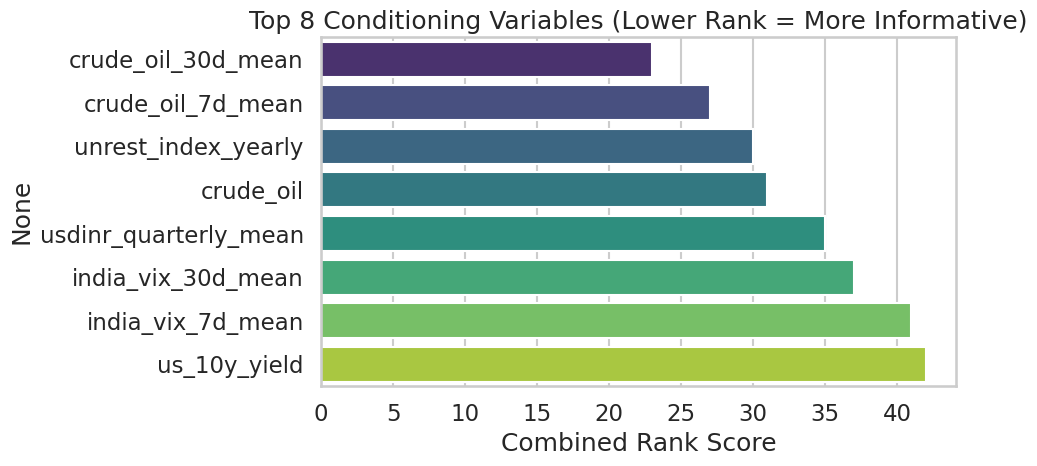


 Full variable ranking saved as 'feature_relevance_ranking.csv'


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# --- Load datasets ---
heston_df = pd.read_csv("NIFTY_heston_single_params_with_date.csv", parse_dates=['Date'])
cond_df = pd.read_csv("conditioning_variables_with_rolling_means.csv", parse_dates=['Unnamed: 0'])

# --- Align on date ---
heston_df.set_index('Date', inplace=True)
cond_df.set_index('Unnamed: 0', inplace=True)
data = cond_df.join(heston_df, how='inner').dropna()

print(f" Combined dataset shape: {data.shape}")

# --- Identify variables ---
condition_vars = [col for col in cond_df.columns if not col.endswith('_above95')]
heston_params = [col for col in heston_df.columns if col.lower() not in ['Date']]

print("Conditioning variables:", condition_vars)
print("Heston parameters:", heston_params)

# --- Standardize conditioning variables ---
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(data[condition_vars]), columns=condition_vars, index=data.index)
Y = data[heston_params]

# --- 1⃣ Pearson correlation ---
corr_scores = {}
for var in condition_vars:
    corr = Y.corrwith(X[var]).abs().mean()  # avg absolute correlation across all params
    corr_scores[var] = corr

# --- 2⃣ Mutual information (nonlinear relationships) ---
mi_scores = {}
for var in condition_vars:
    mi = 0
    for param in heston_params:
        mi += mutual_info_regression(X[[var]], Y[param])[0]
    mi_scores[var] = mi / len(heston_params)

# --- 3⃣ Simple regressions (R² values) ---
r2_scores = {}
for var in condition_vars:
    r2_total = 0
    for param in heston_params:
        model = LinearRegression()
        model.fit(X[[var]], Y[param])
        preds = model.predict(X[[var]])
        r2_total += r2_score(Y[param], preds)
    r2_scores[var] = r2_total / len(heston_params)

# --- Combine all metrics ---
score_df = pd.DataFrame({
    'corr_score': pd.Series(corr_scores),
    'mutual_info': pd.Series(mi_scores),
    'r2_score': pd.Series(r2_scores)
})
score_df['combined_rank'] = (
    score_df['corr_score'].rank(ascending=False) +
    score_df['mutual_info'].rank(ascending=False) +
    score_df['r2_score'].rank(ascending=False)
)

# --- Sort and extract top 5 ---
top_features = score_df.sort_values('combined_rank').head(8)
print("\n Top 8 Most Informative Conditioning Variables:")
print(top_features)

# --- Optional: visualize results ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(y=top_features.index, x=top_features['combined_rank'], palette='viridis')
plt.title("Top 8 Conditioning Variables (Lower Rank = More Informative)")
plt.xlabel("Combined Rank Score")
plt.tight_layout()
plt.show()

# --- Save feature ranking ---
score_df.to_csv("feature_relevance_ranking.csv")
print("\n Full variable ranking saved as 'feature_relevance_ranking.csv'")

In [ ]:
import pandas as pd

# --- Load your conditioning dataset (with rolling mean features) ---
cond_df = pd.read_csv("conditioning_variables_with_rolling_means.csv", parse_dates=['Unnamed: 0'])
cond_df.set_index('Unnamed: 0', inplace=True)

# --- Define the top 8 conditioning variables ---
top_8_vars = [
    'crude_oil_30d_mean',
    'crude_oil_7d_mean',
    'unrest_index_yearly',
    'crude_oil',
    'usdinr_quarterly_mean',
    'india_vix_30d_mean',
    'india_vix_7d_mean',
    'us_10y_yield'
]

# --- Create new dataframe ---
cond_top8_df = cond_df[top_8_vars].copy()

# --- Save it ---
cond_top8_df.to_csv("conditioning_variables_top8.csv")

print(" Created new dataframe with top 8 conditioning variables:")
print(top_8_vars)
print(f"Shape: {cond_top8_df.shape}")
print(" Saved as 'conditioning_variables_top8.csv'")

 Created new dataframe with top 8 conditioning variables:
['crude_oil_30d_mean', 'crude_oil_7d_mean', 'unrest_index_yearly', 'crude_oil', 'usdinr_quarterly_mean', 'india_vix_30d_mean', 'india_vix_7d_mean', 'us_10y_yield']
Shape: (500, 8)
 Saved as 'conditioning_variables_top8.csv'
